The notebook is articolated in two main sections, namely the "Simulation result post-processing" and the "Abaqus-Python code". The first section is the post-processing of the results of the FEM simulations performed in Abaqus with the code reported in "Abaqus-Python code" section and it checks for the satisfaction on the constraints on the maximum allowable stress and slope deviation, with a final Pareto analysis for observing the parameters which affects the most the accepted solutions. The simulation results are available at the following link: https://polimi365-my.sharepoint.com/:u:/g/personal/10546984_polimi_it/ETs4jKP9lJhLmXJxxaRzjMsBO0FnOirsZyefOXBTrovxuA?e=NY6HKv

## Simulation result post-processing

In [39]:
%matplotlib inline
import scipy as sp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter 

## folder definition

root_dir = './'
work_dir = r'C:\Users\lucio\Desktop\MAGALDI\Simulazioni'

## Coefficienti normativa

Cweight = 1.4
Cwind = 1.5

## constraints

limit_stress = 85 #MPa
limit_slopedev = 0.001

## Loading results

configurationNames = np.loadtxt(r"C:\Users\lucio\Desktop\MAGALDI\Configuration_Names.txt", dtype = 'str')
#print(configurationNames)

simulationNames = ["_Peso.txt", "_Temp.txt", "_VO.txt"]

## Plate stress

stress_collected = np.zeros((len(configurationNames),len(simulationNames)))
stress_max = np.zeros((len(configurationNames)))

for kk in range(0,len(configurationNames)):
    
    stress = np.zeros((len(simulationNames)))
    #print(configurationNames[kk])
    
    for jj in range(0,len(simulationNames)):
    
        addName = simulationNames[jj]
        #print(addName)
    
        FileName = work_dir + '/' + configurationNames[kk] + '/' + configurationNames[kk] + '_Plate_VM' + addName
        #print(FileName)
        
        if addName == '_Temp.txt':
            coef = 1
        elif addName == '_Peso.txt':
            coef = Cweight 
        else:   
            coef = Cwind
            
        data = np.loadtxt(FileName, skiprows=3)
        
        xcord = np.zeros(len(data))
        VM = np.zeros(len(data))

        for ii in range (0,len(data)):
            xcord[ii] = data[ii][0]
            VM[ii] = data[ii][1]*coef

        stress[jj] = max(VM)
        
    stress_collected[kk,:] = stress
    stress_max[kk] = np.sum(stress)

#print(stress_collected)
#print(stress_max)      

indx_stress = np.argwhere(stress_max < limit_stress)
print(len(indx_stress),' configurations satisfy the limit on maximum stress for the plate')#, indx_stress+1)

700  configurations satisfy the limit on maximum stress for the plate


In [40]:
## Slope deviation

SlopeDeviation = np.zeros(len(configurationNames))

for kk in range(0,len(configurationNames)):
    
    stress = np.zeros((len(simulationNames)))
    #print(configurationNames[kk])
    
    rot_collected = 0
    
    for jj in range(0,len(simulationNames)):
        
        addName = simulationNames[jj]
        #print(addName)
    
        FileName = work_dir + '/' + configurationNames[kk] + '/' + configurationNames[kk] + '_Plate_UR' + addName
        #print(FileName)
               
        data = np.loadtxt(FileName, skiprows=3)
        
        xcord = np.zeros(len(data))
        rot_temp = np.zeros(len(data))

        for ii in range (0,len(data)):
            xcord[ii] = data[ii][0]
            rot_temp[ii] = data[ii][1]
            
        #print(rot_temp)    
        rot_collected = rot_collected + rot_temp
        #print(rot_collected)
        #rot_collected.shape
    
    dxdy = xcord[1]*xcord[1]
    
    temp = 0
    SDx_mean = 0
    for hh in range(0,len(rot_collected)):
        temp = rot_collected[hh]*dxdy
        SDx_mean = SDx_mean + temp
    SDx_mean = SDx_mean/(800*800)
    
    temp = 0
    SDx_std = 0
    for hh in range(0,len(rot_collected)):
        temp = ((rot_collected[hh] - SDx_mean)**2)*dxdy
        SDx_std = SDx_std + temp
    SDx_std = np.sqrt(SDx_std/(800*800))
    
    temp = 0
    SDx_rms = 0
    for hh in range(0,len(rot_collected)):
        temp1 = (rot_collected[hh]**2)*dxdy
        SDx_rms = SDx_rms + temp
    SDx_rms = np.sqrt(SDx_rms/(800*800))
    
    if SDx_mean < SDx_rms:
        SlopeDeviation[kk] = SDx_rms  
    else:
        SlopeDeviation[kk] = SDx_mean  
    
#print(SlopeDeviation)

indx_slope = np.argwhere(SlopeDeviation < limit_slopedev)
print(len(indx_slope),' configurations satisfy the limit on slope deviation')#, indx_slope+1)


45  configurations satisfy the limit on slope deviation


Slope deviation constraint is more stringent than stress constraint


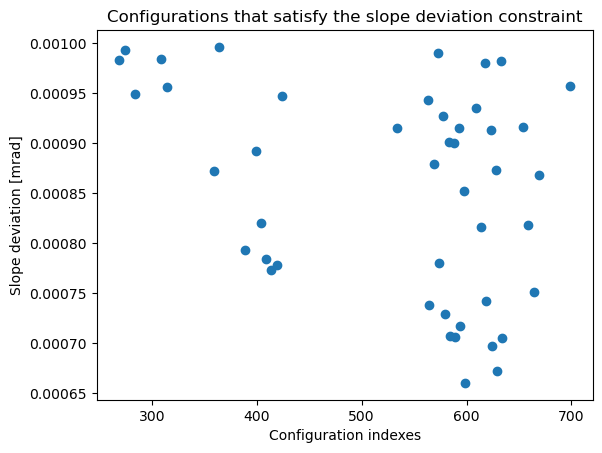

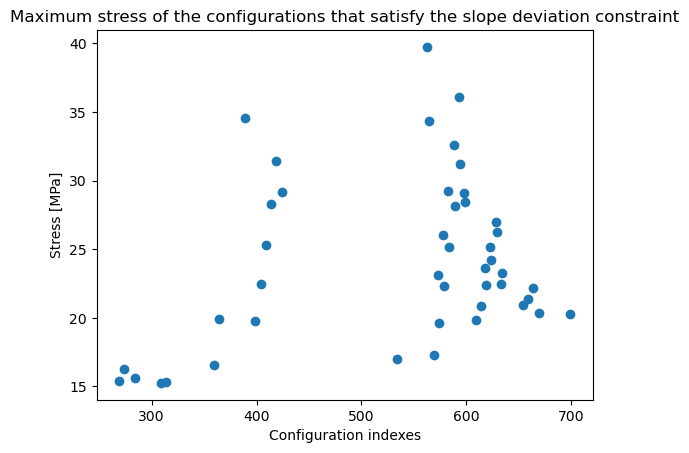

In [41]:
if len(indx_slope) < len(indx_stress):
    print("Slope deviation constraint is more stringent than stress constraint")
else:
    print("Stress constraint is more stringent than slope deviation constraint")

## Plotting

plt.scatter(indx_slope,SlopeDeviation[indx_slope])
plt.title("Configurations that satisfy the slope deviation constraint")
plt.xlabel("Configuration indexes")
plt.ylabel("Slope deviation [mrad]")
plt.show()

plt.scatter(indx_slope,stress_max[indx_slope])
plt.title("Maximum stress of the configurations that satisfy the slope deviation constraint")
plt.xlabel("Configuration indexes")
plt.ylabel("Stress [MPa]")
plt.show()


#C counter:  Counter({9: 31, 8: 9, 7: 5})
C thickness:  Counter({2: 19, 3: 13, 4: 8, 1: 3, 5: 2})
C height:  Counter({100: 10, 80: 8, 90: 8, 70: 7, 50: 5, 60: 4, 40: 3})
plate thickness:  Counter({5: 34, 4: 11})


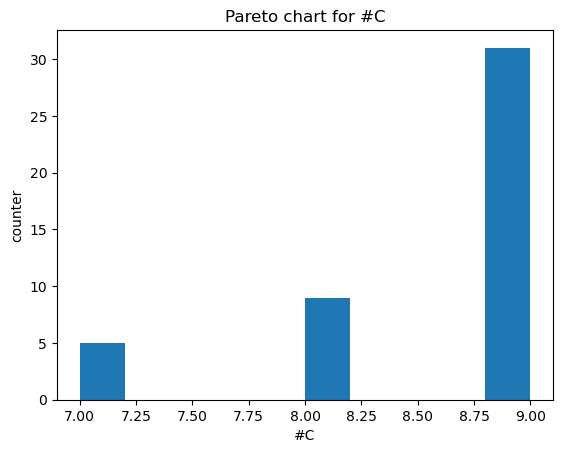

In [42]:
## Pareto analysis to find the parameters that impact the most on the slope deviation

ConfFinal = np.zeros(len(indx_slope))
numC = np.zeros(len(indx_slope), dtype=int)
C_thickness = np.zeros(len(indx_slope), dtype=int)
C_height = np.zeros(len(indx_slope), dtype=int)
plate_thickness = np.zeros(len(indx_slope), dtype=int)

for ii in range(len(indx_slope)):
    jj = indx_slope[ii]
    temp = str(configurationNames[jj])

    if len(temp) == 27:
        numC[ii] = int(temp[4])
        C_thickness[ii] = int(temp[9:11])/10
        C_height[ii] = int(temp[15:19])/10
        plate_thickness[ii] = int(temp[23:25])/10
    else:
        numC[ii] = int(temp[4])
        C_thickness[ii] = int(temp[9:11])/10
        C_height[ii] = int(temp[15:18])/10
        plate_thickness[ii] = int(temp[22:24])/10

numC_counter = (Counter(numC))    
print('#C counter: ', numC_counter)
tot_numC = len(numC)

C_thickness_counter = Counter(C_thickness)
print('C thickness: ', C_thickness_counter)
tot_Ct = len(C_thickness)

C_height_counter = Counter(C_height)   
print('C height: ', C_height_counter)
tot_Ch = len(C_height)

plate_thickness_counter = Counter(plate_thickness)   
print('plate thickness: ', plate_thickness_counter)
tot_pt = len(plate_thickness)

numC_vect = np.linspace(7, 9, 3)
Ct_vect = np.linspace(10, 50, 5)
Ch_vect = np.linspace(400, 1000, 7)
pt_vect = np.linspace(40, 50, 2)

numC_perc = np.zeros(len(numC_vect))
Ct_perc = np.zeros(len(Ct_vect))
Ch_perc = np.zeros(len(Ch_vect))
pt_perc = np.zeros(len(pt_vect))

for ii in range(0,len(numC_vect)):
    indx = numC_vect[ii]
    numC_perc[ii] = 100*numC_counter[indx]/len(indx_slope)

for ii in range(0,len(Ct_vect)):
    indx = Ct_vect[ii]
    Ct_perc[ii] = 100*C_thickness_counter[indx]/len(indx_slope)

for ii in range(0,len(Ch_vect)):
    indx = Ch_vect[ii]
    Ch_perc[ii] = 100*C_height_counter[indx]/len(indx_slope)

for ii in range(0,len(pt_vect)):
    indx = pt_vect[ii]
    pt_perc[ii] = 100*plate_thickness_counter[indx]/len(indx_slope)   

fig, ax = plt.subplots()  
plt.hist(numC)
ax.set_title('Pareto chart for #C')
ax.set(xlabel='#C', ylabel='counter')
plt.show()


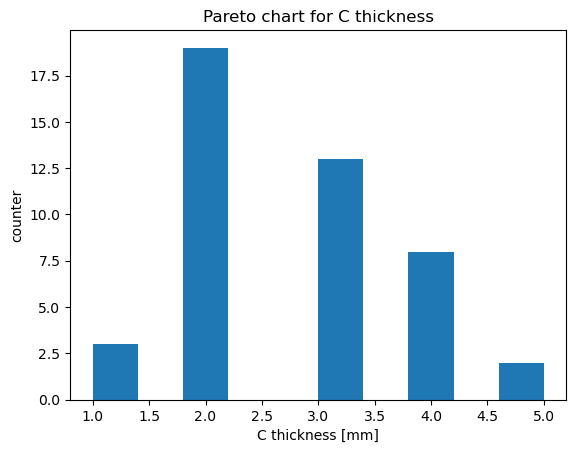

In [43]:
fig, ax = plt.subplots()  
plt.hist(C_thickness)
ax.set_title('Pareto chart for C thickness')
ax.set(xlabel='C thickness [mm]', ylabel='counter')
plt.show()

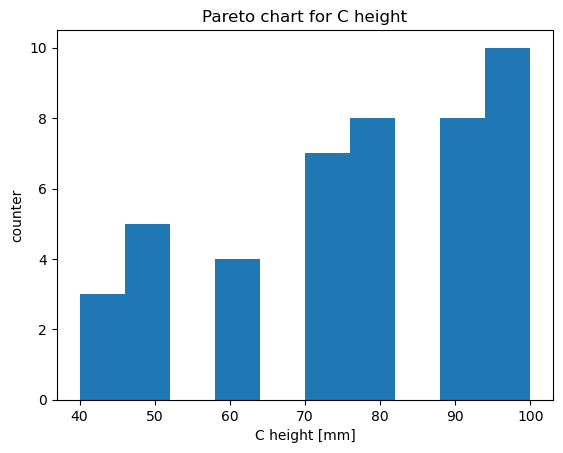

In [44]:
fig, ax = plt.subplots()  
plt.hist(C_height)
ax.set_title('Pareto chart for C height')
ax.set(xlabel='C height [mm]', ylabel='counter')
plt.show()

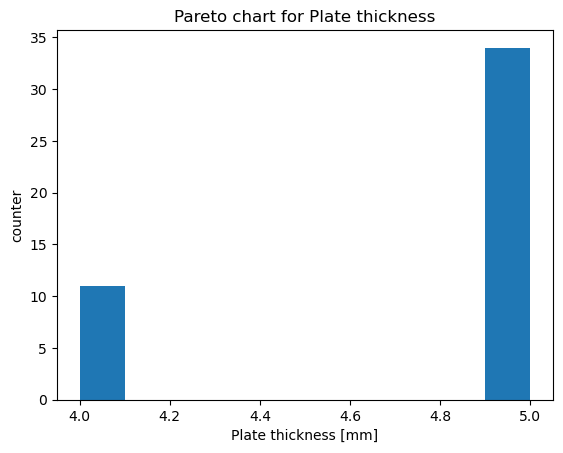

In [45]:
fig, ax = plt.subplots()  
plt.hist(plate_thickness)
ax.set_title('Pareto chart for Plate thickness')
ax.set(xlabel='Plate thickness [mm]', ylabel='counter')
plt.show()

In [46]:
## Cs stress

stress_collected = np.zeros((len(configurationNames),len(simulationNames)))
stress_max = np.zeros((len(configurationNames)))

for kk in range(0,len(configurationNames)):
    
    stress = np.zeros((len(simulationNames)))
    #print(configurationNames[kk])
    
    for jj in range(0,len(simulationNames)):
    
        addName = simulationNames[jj]
        #print(addName)
    
        FileName = work_dir + '/' + configurationNames[kk] + '/' + configurationNames[kk] + '_C_VD_VM' + addName
        #print(FileName)
        
        if addName == '_Temp.txt':
            coef = 1
        elif addName == '_Peso.txt':
            coef = Cweight 
        else:   
            coef = Cwind
            
        data = np.loadtxt(FileName, skiprows=3)
        
        xcord = np.zeros(len(data))
        VM = np.zeros(len(data))

        for ii in range (0,len(data)):
            xcord[ii] = data[ii][0]
            VM[ii] = data[ii][1]*coef

        stress[jj] = max(VM)
        
    stress_collected[kk,:] = stress
    stress_max[kk] = np.sum(stress)

#print(stress_collected)
#print(stress_max)      

indx_stress_C_VD = np.argwhere(stress_max < limit_stress)
print(len(indx_stress_C_VD),' configurations satisfy the limit on maximum stress for the lower-central C')#, indx_stress+1)

stress_collected = np.zeros((len(configurationNames),len(simulationNames)))
stress_max = np.zeros((len(configurationNames)))

for kk in range(0,len(configurationNames)):
    
    stress = np.zeros((len(simulationNames)))
    #print(configurationNames[kk])
    
    for jj in range(0,len(simulationNames)):
    
        addName = simulationNames[jj]
        #print(addName)
    
        FileName = work_dir + '/' + configurationNames[kk] + '/' + configurationNames[kk] + '_C_VU_VM' + addName
        #print(FileName)
        
        if addName == '_Temp.txt':
            coef = 1
        elif addName == '_Peso.txt':
            coef = Cweight 
        else:   
            coef = Cwind
            
        data = np.loadtxt(FileName, skiprows=3)
        
        xcord = np.zeros(len(data))
        VM = np.zeros(len(data))

        for ii in range (0,len(data)):
            xcord[ii] = data[ii][0]
            VM[ii] = data[ii][1]*coef

        stress[jj] = max(VM)
        
    stress_collected[kk,:] = stress
    stress_max[kk] = np.sum(stress)

#print(stress_collected)
#print(stress_max)      

indx_stress_C_VU = np.argwhere(stress_max < limit_stress)
print(len(indx_stress_C_VU),' configurations satisfy the limit on maximum stress for the upper-central C')#, indx_stress+1)

stress_collected = np.zeros((len(configurationNames),len(simulationNames)))
stress_max = np.zeros((len(configurationNames)))

for kk in range(0,len(configurationNames)):
    
    stress = np.zeros((len(simulationNames)))
    #print(configurationNames[kk])
    
    for jj in range(0,len(simulationNames)):
    
        addName = simulationNames[jj]
        #print(addName)
    
        FileName = work_dir + '/' + configurationNames[kk] + '/' + configurationNames[kk] + '_C_UL_VM' + addName
        #print(FileName)
        
        if addName == '_Temp.txt':
            coef = 1
        elif addName == '_Peso.txt':
            coef = Cweight 
        else:   
            coef = Cwind
            
        data = np.loadtxt(FileName, skiprows=3)
        
        xcord = np.zeros(len(data))
        VM = np.zeros(len(data))

        for ii in range (0,len(data)):
            xcord[ii] = data[ii][0]
            VM[ii] = data[ii][1]*coef

        stress[jj] = max(VM)
        
    stress_collected[kk,:] = stress
    stress_max[kk] = np.sum(stress)

#print(stress_collected)
#print(stress_max)      

indx_stress_C_UL = np.argwhere(stress_max < limit_stress)
print(len(indx_stress_C_UL),' configurations satisfy the limit on maximum stress  for the upper-left C')#, indx_stress+1)

stress_collected = np.zeros((len(configurationNames),len(simulationNames)))
stress_max = np.zeros((len(configurationNames)))

for kk in range(0,len(configurationNames)):
    
    stress = np.zeros((len(simulationNames)))
    #print(configurationNames[kk])
    
    for jj in range(0,len(simulationNames)):
    
        addName = simulationNames[jj]
        #print(addName)
    
        FileName = work_dir + '/' + configurationNames[kk] + '/' + configurationNames[kk] + '_C_UR_VM' + addName
        #print(FileName)
        
        if addName == '_Temp.txt':
            coef = 1
        elif addName == '_Peso.txt':
            coef = Cweight 
        else:   
            coef = Cwind
            
        data = np.loadtxt(FileName, skiprows=3)
        
        xcord = np.zeros(len(data))
        VM = np.zeros(len(data))

        for ii in range (0,len(data)):
            xcord[ii] = data[ii][0]
            VM[ii] = data[ii][1]*coef

        stress[jj] = max(VM)
        
    stress_collected[kk,:] = stress
    stress_max[kk] = np.sum(stress)

#print(stress_collected)
#print(stress_max)      

indx_stress_C_UR = np.argwhere(stress_max < limit_stress)
print(len(indx_stress_C_UR),' configurations satisfy the limit on maximum stress for the upper-right C')#, indx_stress+1)

stress_collected = np.zeros((len(configurationNames),len(simulationNames)))
stress_max = np.zeros((len(configurationNames)))

for kk in range(0,len(configurationNames)):
    
    stress = np.zeros((len(simulationNames)))
    #print(configurationNames[kk])
    
    for jj in range(0,len(simulationNames)):
    
        addName = simulationNames[jj]
        #print(addName)
    
        FileName = work_dir + '/' + configurationNames[kk] + '/' + configurationNames[kk] + '_C_VD_VM' + addName
        #print(FileName)
        
        if addName == '_Temp.txt':
            coef = 1
        elif addName == '_Peso.txt':
            coef = Cweight 
        else:   
            coef = Cwind
            
        data = np.loadtxt(FileName, skiprows=3)
        
        xcord = np.zeros(len(data))
        VM = np.zeros(len(data))

        for ii in range (0,len(data)):
            xcord[ii] = data[ii][0]
            VM[ii] = data[ii][1]*coef

        stress[jj] = max(VM)
        
    stress_collected[kk,:] = stress
    stress_max[kk] = np.sum(stress)

#print(stress_collected)
#print(stress_max)      

indx_stress_C_ML = np.argwhere(stress_max < limit_stress)
print(len(indx_stress_C_ML),' configurations satisfy the limit on maximum stress for the middle-left C')#, indx_stress+1)

stress_collected = np.zeros((len(configurationNames),len(simulationNames)))
stress_max = np.zeros((len(configurationNames)))

for kk in range(0,len(configurationNames)):
    
    stress = np.zeros((len(simulationNames)))
    #print(configurationNames[kk])
    
    for jj in range(0,len(simulationNames)):
    
        addName = simulationNames[jj]
        #print(addName)
    
        FileName = work_dir + '/' + configurationNames[kk] + '/' + configurationNames[kk] + '_C_MR_VM' + addName
        #print(FileName)
        
        if addName == '_Temp.txt':
            coef = 1
        elif addName == '_Peso.txt':
            coef = Cweight 
        else:   
            coef = Cwind
            
        data = np.loadtxt(FileName, skiprows=3)
        
        xcord = np.zeros(len(data))
        VM = np.zeros(len(data))

        for ii in range (0,len(data)):
            xcord[ii] = data[ii][0]
            VM[ii] = data[ii][1]*coef

        stress[jj] = max(VM)
        
    stress_collected[kk,:] = stress
    stress_max[kk] = np.sum(stress)

#print(stress_collected)
#print(stress_max)      

indx_stress_C_MR = np.argwhere(stress_max < limit_stress)
print(len(indx_stress_C_MR),' configurations satisfy the limit on maximum stress  for the middle-right C')#, indx_stress+1)

stress_collected = np.zeros((len(configurationNames),len(simulationNames)))
stress_max = np.zeros((len(configurationNames)))

for kk in range(0,len(configurationNames)):
    
    stress = np.zeros((len(simulationNames)))
    #print(configurationNames[kk])
    
    for jj in range(0,len(simulationNames)):
    
        addName = simulationNames[jj]
        #print(addName)
    
        FileName = work_dir + '/' + configurationNames[kk] + '/' + configurationNames[kk] + '_C_DL_VM' + addName
        #print(FileName)
        
        if addName == '_Temp.txt':
            coef = 1
        elif addName == '_Peso.txt':
            coef = Cweight 
        else:   
            coef = Cwind
            
        data = np.loadtxt(FileName, skiprows=3)
        
        xcord = np.zeros(len(data))
        VM = np.zeros(len(data))

        for ii in range (0,len(data)):
            xcord[ii] = data[ii][0]
            VM[ii] = data[ii][1]*coef

        stress[jj] = max(VM)
        
    stress_collected[kk,:] = stress
    stress_max[kk] = np.sum(stress)

#print(stress_collected)
#print(stress_max)      

indx_stress_C_DL = np.argwhere(stress_max < limit_stress)
print(len(indx_stress_C_DL),' configurations satisfy the limit on maximum stress  for the lower-left C')#, indx_stress+1)

stress_collected = np.zeros((len(configurationNames),len(simulationNames)))
stress_max = np.zeros((len(configurationNames)))

for kk in range(0,len(configurationNames)):
    
    stress = np.zeros((len(simulationNames)))
    #print(configurationNames[kk])
    
    for jj in range(0,len(simulationNames)):
    
        addName = simulationNames[jj]
        #print(addName)
    
        FileName = work_dir + '/' + configurationNames[kk] + '/' + configurationNames[kk] + '_C_DR_VM' + addName
        #print(FileName)
        
        if addName == '_Temp.txt':
            coef = 1
        elif addName == '_Peso.txt':
            coef = Cweight 
        else:   
            coef = Cwind
            
        data = np.loadtxt(FileName, skiprows=3)
        
        xcord = np.zeros(len(data))
        VM = np.zeros(len(data))

        for ii in range (0,len(data)):
            xcord[ii] = data[ii][0]
            VM[ii] = data[ii][1]*coef

        stress[jj] = max(VM)
        
    stress_collected[kk,:] = stress
    stress_max[kk] = np.sum(stress)

#print(stress_collected)
#print(stress_max)      

indx_stress_C_DR = np.argwhere(stress_max < limit_stress)
print(len(indx_stress_C_DR),' configurations satisfy the limit on maximum stress for the lower-right C')#, indx_stress_C_DR+1)

stress_collected = np.zeros((len(configurationNames),len(simulationNames)))
stress_max = np.zeros((len(configurationNames)))

for kk in range(0,len(configurationNames)):
    
    stress = np.zeros((len(simulationNames)))
    #print(configurationNames[kk])
    
    for jj in range(0,len(simulationNames)):
    
        addName = simulationNames[jj]
        #print(addName)
    
        FileName = work_dir + '/' + configurationNames[kk] + '/' + configurationNames[kk] + '_C_C_VM' + addName
        #print(FileName)
        
        if addName == '_Temp.txt':
            coef = 1
        elif addName == '_Peso.txt':
            coef = Cweight 
        else:   
            coef = Cwind
            
        data = np.loadtxt(FileName, skiprows=3)
        
        xcord = np.zeros(len(data))
        VM = np.zeros(len(data))

        for ii in range (0,len(data)):
            xcord[ii] = data[ii][0]
            VM[ii] = data[ii][1]*coef

        stress[jj] = max(VM)
        
    stress_collected[kk,:] = stress
    stress_max[kk] = np.sum(stress)

#print(stress_collected)
#print(stress_max)      

indx_stress_C_C = np.argwhere(stress_max < limit_stress)
print(len(indx_stress_C_C),' configurations satisfy the limit on maximum stress for the central C')#, indx_stress_C_C+1)

534  configurations satisfy the limit on maximum stress for the lower-central C
523  configurations satisfy the limit on maximum stress for the upper-central C
174  configurations satisfy the limit on maximum stress  for the upper-left C
123  configurations satisfy the limit on maximum stress for the upper-right C
534  configurations satisfy the limit on maximum stress for the middle-left C
310  configurations satisfy the limit on maximum stress  for the middle-right C
158  configurations satisfy the limit on maximum stress  for the lower-left C
155  configurations satisfy the limit on maximum stress for the lower-right C
642  configurations satisfy the limit on maximum stress for the central C


In [48]:
t = np.intersect1d(indx_stress,indx_slope) 
t1 = np.intersect1d(t,indx_stress_C_VD)
t = np.intersect1d(t1,indx_stress_C_VU)
t1 = np.intersect1d(t,indx_stress_C_UL)
t = np.intersect1d(t1,indx_stress_C_UR)
t1 = np.intersect1d(t,indx_stress_C_UL)
t = np.intersect1d(t1,indx_stress_C_ML)
t1 = np.intersect1d(t,indx_stress_C_MR)
t = np.intersect1d(t1,indx_stress_C_DL)
t1 = np.intersect1d(t,indx_stress_C_DR)
t = np.intersect1d(t1,indx_stress_C_C)

print(len(t),' configurations satisfy all the constraints: ', t+1)
print(configurationNames[t])

4  configurations satisfy all the constraints:  [425 599 600 634]
['C_8_TC_30_HC_1000_TP_50' 'C_9_TC_30_HC_1000_TP_40'
 'C_9_TC_30_HC_1000_TP_50' 'C_9_TC_40_HC_1000_TP_40']


#C counter:  Counter({9: 3, 8: 1})
C thickness:  Counter({3: 3, 4: 1})
C height:  Counter({100: 4})
plate thickness:  Counter({5: 2, 4: 2})


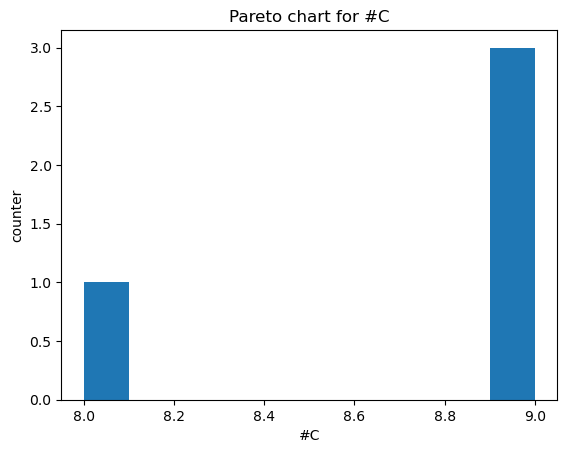

In [59]:
## Pareto analysis to find the parameters that impact the most on the final configurations

ConfFinal = np.zeros(len(t))
numC = np.zeros(len(t), dtype=int)
C_thickness = np.zeros(len(t), dtype=int)
C_height = np.zeros(len(t), dtype=int)
plate_thickness = np.zeros(len(t), dtype=int)

for ii in range(len(t)):
    jj = t[ii]
    temp = str(configurationNames[jj])

    if len(temp) == 23:
        numC[ii] = int(temp[2])
        C_thickness[ii] = int(temp[7:9])/10
        C_height[ii] = int(temp[13:17])/10
        plate_thickness[ii] = int(temp[21:23])/10
    else:
        numC[ii] = int(temp[2])
        C_thickness[ii] = int(temp[7:9])/10
        C_height[ii] = int(temp[13:16])/10
        plate_thickness[ii] = int(temp[20:22])/10

numC_counter = (Counter(numC))    
print('#C counter: ', numC_counter)
tot_numC = len(numC)

C_thickness_counter = Counter(C_thickness)
print('C thickness: ', C_thickness_counter)
tot_Ct = len(C_thickness)

C_height_counter = Counter(C_height)   
print('C height: ', C_height_counter)
tot_Ch = len(C_height)

plate_thickness_counter = Counter(plate_thickness)   
print('plate thickness: ', plate_thickness_counter)
tot_pt = len(plate_thickness)

numC_vect = np.linspace(7, 9, 3)
Ct_vect = np.linspace(10, 50, 5)
Ch_vect = np.linspace(400, 1000, 7)
pt_vect = np.linspace(40, 50, 2)

numC_perc = np.zeros(len(numC_vect))
Ct_perc = np.zeros(len(Ct_vect))
Ch_perc = np.zeros(len(Ch_vect))
pt_perc = np.zeros(len(pt_vect))

for ii in range(0,len(numC_vect)):
    indx = numC_vect[ii]
    numC_perc[ii] = 100*numC_counter[indx]/len(indx_slope)

for ii in range(0,len(Ct_vect)):
    indx = Ct_vect[ii]
    Ct_perc[ii] = 100*C_thickness_counter[indx]/len(indx_slope)

for ii in range(0,len(Ch_vect)):
    indx = Ch_vect[ii]
    Ch_perc[ii] = 100*C_height_counter[indx]/len(indx_slope)

for ii in range(0,len(pt_vect)):
    indx = pt_vect[ii]
    pt_perc[ii] = 100*plate_thickness_counter[indx]/len(indx_slope)   

fig, ax = plt.subplots()  
plt.hist(numC)
ax.set_title('Pareto chart for #C')
ax.set(xlabel='#C', ylabel='counter')
plt.show()

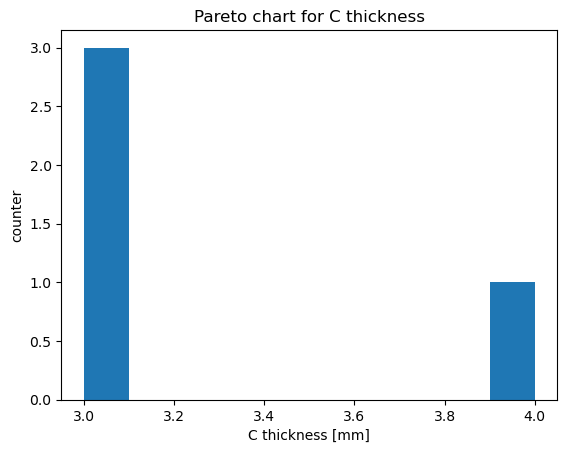

In [60]:
fig, ax = plt.subplots()  
plt.hist(C_thickness)
ax.set_title('Pareto chart for C thickness')
ax.set(xlabel='C thickness [mm]', ylabel='counter')
plt.show()

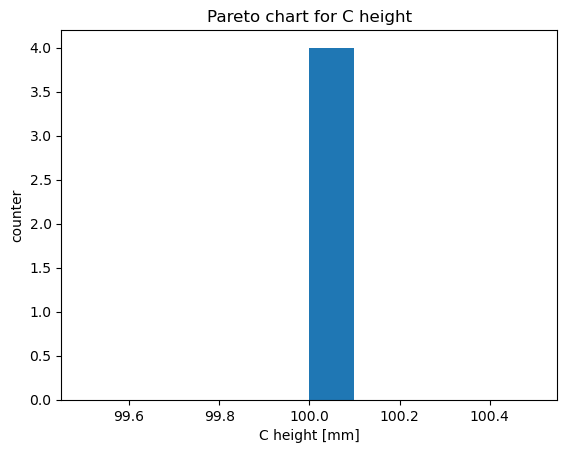

In [61]:
fig, ax = plt.subplots()  
plt.hist(C_height)
ax.set_title('Pareto chart for C height')
ax.set(xlabel='C height [mm]', ylabel='counter')
plt.show()

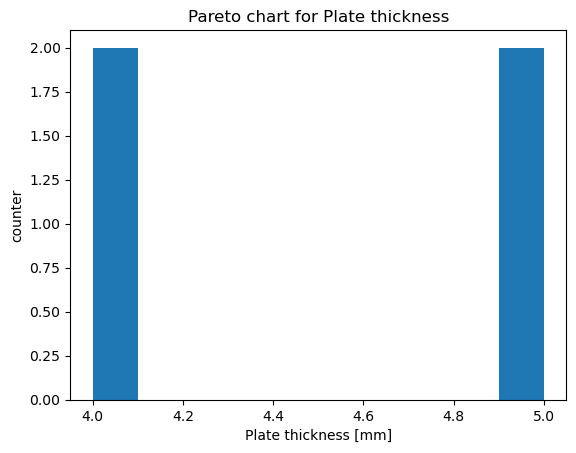

In [62]:
fig, ax = plt.subplots()  
plt.hist(plate_thickness)
ax.set_title('Pareto chart for Plate thickness')
ax.set(xlabel='Plate thickness [mm]', ylabel='counter')
plt.show()

In [55]:
len(configurationNames[t[1]])

23

## Abaqus-Python code

In [ ]:
## Abaqus script

import numpy as np

import os

from abaqus import *
from abaqusConstants import *
from caeModules import *
from driverUtils import executeOnCaeStartup

# Defining the directories

root_dir = './'
work_dir = r'/global-scratch/bulk_pool/massimo/Lucio'

openMdb('Solar_Grid_Specchio_Basemodel_v1.cae')

# Changing the working directory if necessary

if root_dir != work_dir:
    os.chdir(work_dir)
    
# Loading the information of all the cases

casi_comp = np.load(os.path.join(work_dir,'Casi_SG.npy'))
ref_var = np.load(os.path.join(work_dir,'ref_var.npy'))
# The first line are the names of the variables
# The second row is the reference

ChangeMesh=0

# Creating the inps
# ref_var = casi_comp[0,:]

casi = casi_comp[0:,:]

for mod in casi:
    count=0
    
# Opening the model

    session.Viewport(name='Viewport: 1', origin=(0.0, 0.0), width=268.18359375, height=142.800003051758)
    session.viewports['Viewport: 1'].makeCurrent()
    session.viewports['Viewport: 1'].maximize()
    executeOnCaeStartup()

    openMdb('Solar_Grid_Specchio_Basemodel_v1.cae')

    session.viewports['Viewport: 1'].setValues(displayedObject=None)
    session.viewports['Viewport: 1'].partDisplay.geometryOptions.setValues(
        referenceRepresentation=ON)
    p = mdb.models['Model-1'].parts['Part-2']
    session.viewports['Viewport: 1'].setValues(displayedObject=p)
    
# Delete previous meshes
    
    session.viewports['Viewport: 1'].setValues(displayedObject=p)
    p = mdb.models['Model-1'].parts['Part-2']
    f = p.faces
    pickedRegions = f.getSequenceFromMask(mask=('[#1f ]', ), )
    p.deleteMesh(regions=pickedRegions)
       
# Enable/disable contacts with external and central supports
    
    session.viewports['Viewport: 1'].view.setValues(nearPlane=2310.15,farPlane=3809.22, width=786.477, height=437.041,
        viewOffsetX=-48.2003, viewOffsetY=33.341)
    mdb.models['Model-1'].constraints['TIE_L_Esterne-Supplementari'].suppress()
    mdb.models['Model-1'].constraints['TIE_L_Centrale'].suppress()
    
    if mod[0,] == 7:
        session.viewports['Viewport: 1'].view.setValues(nearPlane=2310.15, farPlane=3809.22, width=786.477, height=437.041,
            viewOffsetX=-48.2003, viewOffsetY=33.341)
        mdb.models['Model-1'].constraints['TIE_L_Centrale'].resume()
    elif mod[0,] == 8:
        session.viewports['Viewport: 1'].view.setValues(nearPlane=2310.15, farPlane=3809.22, width=786.477, height=437.041,
            viewOffsetX=-48.2003, viewOffsetY=33.341)
        mdb.models['Model-1'].constraints['TIE_L_Esterne-Supplementari'].resume()
    elif mod[0,] == 9:
        session.viewports['Viewport: 1'].view.setValues(nearPlane=2310.15, farPlane=3809.22, width=786.477, height=437.041,
            viewOffsetX=-48.2003, viewOffsetY=33.341)
        mdb.models['Model-1'].constraints['TIE_L_Esterne-Supplementari'].resume()
        mdb.models['Model-1'].constraints['TIE_L_Centrale'].resume()

# C thickness

    tC = mod[1,]
    p = mdb.models['Model-1'].parts['Part-1']
    session.viewports['Viewport: 1'].setValues(displayedObject=p)
    mdb.models['Model-1'].sections['SHELL_Staffa'].setValues(preIntegrate=OFF, 
        material='ACCIAIO', thicknessType=UNIFORM, thickness=tC, 
        thicknessField='', nodalThicknessField='', idealization=NO_IDEALIZATION, 
        integrationRule=SIMPSON, numIntPts=5)
        
# C heigth

    hC = mod[2,]
    p = mdb.models['Model-1'].parts['Part-2']
    session.viewports['Viewport: 1'].setValues(displayedObject=p)
    p = mdb.models['Model-1'].parts['Part-2']
    s = p.features['Shell extrude-1'].sketch
    mdb.models['Model-1'].ConstrainedSketch(name='__edit__', objectToCopy=s)
    s2 = mdb.models['Model-1'].sketches['__edit__']
    g, v, d, c = s2.geometry, s2.vertices, s2.dimensions, s2.constraints
    s2.setPrimaryObject(option=SUPERIMPOSE)
    p.projectReferencesOntoSketch(sketch=s2, 
        upToFeature=p.features['Shell extrude-1'], filter=COPLANAR_EDGES)
    d[1].setValues(value=hC, )
    s2.unsetPrimaryObject()
    p = mdb.models['Model-1'].parts['Part-2']
    p.features['Shell extrude-1'].setValues(sketch=s2)
    del mdb.models['Model-1'].sketches['__edit__']
    p = mdb.models['Model-1'].parts['Part-2']
    p.regenerate()
        
# Plate thickness
    tP = mod[3,]
    session.viewports['Viewport: 1'].setValues(displayedObject=p)
    session.viewports['Viewport: 1'].partDisplay.setValues(sectionAssignments=ON, 
        engineeringFeatures=ON)
    session.viewports['Viewport: 1'].partDisplay.geometryOptions.setValues(
        referenceRepresentation=OFF)
    mdb.models['Model-1'].sections['SHELL_PLATE'].setValues(preIntegrate=OFF, 
        material='ACCIAIO', thicknessType=UNIFORM, thickness=tP, 
        thicknessField='', nodalThicknessField='', idealization=NO_IDEALIZATION, 
    integrationRule=SIMPSON, numIntPts=5)

# Generate new meshes
    
    session.viewports['Viewport: 1'].view.setValues(nearPlane=161.683, 
        farPlane=411.672, width=326.932, height=181.675, viewOffsetX=48.1227, 
        viewOffsetY=30.9495)
    session.viewports['Viewport: 1'].partDisplay.setValues(mesh=ON)
    session.viewports['Viewport: 1'].partDisplay.meshOptions.setValues(
        meshTechnique=ON)
    session.viewports['Viewport: 1'].partDisplay.geometryOptions.setValues(
        referenceRepresentation=OFF)
    p = mdb.models['Model-1'].parts['Part-2']
    session.viewports['Viewport: 1'].setValues(displayedObject=p)
    p.generateMesh()
   
# Job creation and submission    
    mod=mod*10
    mod[0] = mod[0]/10
    mod=mod.astype(int)
    JobName = [str(element) for element in mod]
    JobName1="_"+(str(JobName[0]))
    JobName2="_"+(str(JobName[1]))
    JobName3="_"+(str(JobName[2]))
    JobName4="_"+(str(JobName[3]))
    JobName = 'C'+ JobName1 + '_TC' + JobName2 + '_HC' +  JobName3 + '_TP' + JobName4
    print(JobName)
    
    os.makedirs(JobName)
    os.makedirs(JobName+'/Peso')
    os.makedirs(JobName+'/Temperatura')
    os.makedirs(JobName+'/Vento Operativo')
    os.makedirs(JobName+'/Vento Massimo')
    
    mdb.Job(name= JobName , model='Model-1', description='', type=ANALYSIS, 
        atTime=None, waitMinutes=0, waitHours=0, queue=None, memory=90, 
        memoryUnits=PERCENTAGE, getMemoryFromAnalysis=True, 
        explicitPrecision=SINGLE, nodalOutputPrecision=SINGLE, echoPrint=OFF, 
        modelPrint=OFF, contactPrint=OFF, historyPrint=OFF, userSubroutine='', 
        scratch='', resultsFormat=ODB, multiprocessingMode=DEFAULT, numCpus=10, 
        numDomains=10, numGPUs=0)
    
    mdb.jobs[JobName].submit(consistencyChecking=OFF)
    mdb.jobs[JobName].waitForCompletion()
    
# Opening ODB

    o1 = session.openOdb(name=JobName+'.odb')
    session.viewports['Viewport: 1'].setValues(displayedObject=o1)

# Simulation results extraction
    
    session.viewports['Viewport: 1'].view.setValues(session.views['Back'])
    session.Path(name='Plate_Upper_Supplementary_C', type=NODE_LIST, expression=(('PART-1-1', (1641, )), ('PART-1-1', (1681, ))))
        
    session.Path(name='Plate_Lower_Supplementary_C', type=NODE_LIST, expression=((
        'PART-1-1', (1, )), ('PART-1-1', (41, ))))
        
    session.Path(name='Plate_Left_C', type=NODE_LIST, expression=(('PART-1-1', (1681, )), 
        ('PART-1-1', (41, ))))
        
    session.Path(name='Plate_Right_C', type=NODE_LIST, expression=(('PART-1-1', (1641, 
        )), ('PART-1-1', (1, ))))
        
    session.Path(name='Plate_V_Center', type=NODE_LIST, expression=(('PART-1-1', (
        1661, )), ('PART-1-1', (21, ))))
        
    session.Path(name='Plate_H_Center', type=NODE_LIST, expression=(('PART-1-1', (
        861, )), ('PART-1-1', (821, ))))
        
    session.pickingExpression._processNodeSets(selectedNodeSets='PART-1-1.SET-1,')
    session.Path(name='Plate', type=NODE_LIST, expression=(('PART-1-1', (1, 2, 3, 
        4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
        24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
        43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 
        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 
        235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 
        250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 
        265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 
        280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 
        295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 
        310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 
        325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 
        340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 
        355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 
        370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 
        385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 
        400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 
        415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 
        430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 
        445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 
        460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 
        475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 
        490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 
        505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 
        520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 
        535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 
        550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 
        565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 
        580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 
        595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 
        610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 
        625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 
        640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 
        655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 
        670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 
        685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 
        700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 
        715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 
        730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 
        745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 
        760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 
        775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 
        790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 
        805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 
        820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 
        835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 
        850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 
        865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 
        880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 
        895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 
        910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 
        925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 
        940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 
        955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 
        970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 
        985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 
        1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 
        1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 
        1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 
        1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 
        1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 
        1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 
        1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 
        1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 
        1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 
        1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 
        1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 
        1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 
        1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 
        1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 
        1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 
        1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 
        1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 
        1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 
        1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 
        1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 
        1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 
        1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 
        1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 
        1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 
        1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 
        1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 
        1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 
        1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 
        1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 
        1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 
        1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 
        1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 
        1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 
        1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 
        1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 
        1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 
        1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 
        1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 
        1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 
        1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 
        1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 
        1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 
        1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 
        1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 
        1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 
        1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 
        1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 
        1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 
        1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 
        1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 
        1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 
        1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 
        1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 
        1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 
        1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 
        1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 
        1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, )), ))
        
    session.pickingExpression._processNodeSets(selectedNodeSets='PART-2-1.SET-1,')
    session.Path(name='C_DR', type=NODE_LIST, expression=(('PART-2-1', (1, 2, 3, 
        4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
        24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
        43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 
        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 
        235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 
        250, 251, 252, 253, 254, 255, 256, 257, )), ))
        
    session.pickingExpression._processNodeSets(selectedNodeSets='PART-2-2.SET-1,')
    session.Path(name='C_UR', type=NODE_LIST, expression=(('PART-2-2', (1, 2, 3, 
        4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
        24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
        43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 
        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 
        235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 
        250, 251, 252, 253, 254, 255, 256, 257, )), ))
        
    session.pickingExpression._processNodeSets(selectedNodeSets='PART-2-3.SET-1,')
    session.Path(name='C_DL', type=NODE_LIST, expression=(('PART-2-3', (1, 2, 3, 
        4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
        24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
        43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 
        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 
        235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 
        250, 251, 252, 253, 254, 255, 256, 257, )), ))    
        
    session.pickingExpression._processNodeSets(selectedNodeSets='PART-2-4.SET-1,')
    session.Path(name='C_UL', type=NODE_LIST, expression=(('PART-2-4', (1, 2, 3, 
        4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
        24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
        43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 
        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 
        235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 
        250, 251, 252, 253, 254, 255, 256, 257, )), ))
    
    session.pickingExpression._processNodeSets(selectedNodeSets='PART-2-5.SET-1,')
    session.Path(name='C_MR', type=NODE_LIST, expression=(('PART-2-5', (1, 2, 3, 
        4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
        24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
        43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 
        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 
        235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 
        250, 251, 252, 253, 254, 255, 256, 257, )), ))
    
    session.pickingExpression._processNodeSets(selectedNodeSets='PART-2-6.SET-1,')
    session.Path(name='C_ML', type=NODE_LIST, expression=(('PART-2-6', (1, 2, 3, 
        4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
        24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
        43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 
        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 
        235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 
        250, 251, 252, 253, 254, 255, 256, 257, )), ))
    
    session.pickingExpression._processNodeSets(selectedNodeSets='PART-2-7.SET-1,')
    session.Path(name='C_VU', type=NODE_LIST, expression=(('PART-2-7', (1, 2, 3, 
        4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
        24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
        43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 
        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 
        235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 
        250, 251, 252, 253, 254, 255, 256, 257, )), ))
    
    session.pickingExpression._processNodeSets(selectedNodeSets='PART-2-8.SET-1,')
    session.Path(name='C_VD', type=NODE_LIST, expression=(('PART-2-8', (1, 2, 3, 
        4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
        24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
        43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 
        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 
        235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 
        250, 251, 252, 253, 254, 255, 256, 257, )), ))
    
    session.pickingExpression._processNodeSets(selectedNodeSets='PART-2-9.SET-1,')
    session.Path(name='C_C', type=NODE_LIST, expression=(('PART-2-9', (1, 2, 3, 
        4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
        24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
        43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 
        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 
        205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 
        235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 
        250, 251, 252, 253, 254, 255, 256, 257, )), ))
    
# Step: Peso
# Von Mises stress 
    session.viewports['Viewport: 1'].odbDisplay.setFrame(step=0, frame=1)
    session.viewports['Viewport: 1'].odbDisplay.setPrimaryVariable(variableLabel='S', outputPosition=INTEGRATION_POINT, refinement=(INVARIANT,'Mises'))
    pth = session.paths['C_C']
    session.XYDataFromPath(name='C_C_VM_Peso', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)
    x0 = session.xyDataObjects['C_C_VM_Peso']
    session.writeXYReport(fileName=JobName+'_C_C_VM_Peso.txt', xyData=(x0, ))
    pth = session.paths['C_DL']
    session.XYDataFromPath(name='C_DL_VM_Peso', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)
    x0 = session.xyDataObjects['C_DL_VM_Peso']
    session.writeXYReport(fileName=JobName+'_C_DL_VM_Peso.txt', xyData=(x0, ))
    pth = session.paths['C_DR']
    session.XYDataFromPath(name='C_DR_VM_Peso', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False) 
    x0 = session.xyDataObjects['C_DR_VM_Peso']
    session.writeXYReport(fileName=JobName+'_C_DR_VM_Peso.txt', xyData=(x0, ))
    pth = session.paths['C_ML']
    session.XYDataFromPath(name='C_ML_VM_Peso', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_ML_VM_Peso']
    session.writeXYReport(fileName=JobName+'_C_ML_VM_Peso.txt', xyData=(x0, ))
    pth = session.paths['C_MR']
    session.XYDataFromPath(name='C_MR_VM_Peso', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_MR_VM_Peso']
    session.writeXYReport(fileName=JobName+'_C_MR_VM_Peso.txt', xyData=(x0, ))
    pth = session.paths['C_UL']
    session.XYDataFromPath(name='C_UL_VM_Peso', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_UL_VM_Peso']
    session.writeXYReport(fileName=JobName+'_C_UL_VM_Peso.txt', xyData=(x0, ))
    pth = session.paths['C_UR']
    session.XYDataFromPath(name='C_UR_VM_Peso', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_UR_VM_Peso']
    session.writeXYReport(fileName=JobName+'_C_UR_VM_Peso.txt', xyData=(x0, ))
    pth = session.paths['C_VU']
    session.XYDataFromPath(name='C_VU_VM_Peso', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_VU_VM_Peso']
    session.writeXYReport(fileName=JobName+'_C_VU_VM_Peso.txt', xyData=(x0, ))
    pth = session.paths['C_VD']
    session.XYDataFromPath(name='C_VD_VM_Peso', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_VD_VM_Peso']
    session.writeXYReport(fileName=JobName+'_C_VD_VM_Peso.txt', xyData=(x0, ))
    pth = session.paths['Plate']
    session.XYDataFromPath(name='Plate_VM_Peso', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['Plate_VM_Peso']
    session.writeXYReport(fileName=JobName+'_Plate_VM_Peso.txt', xyData=(x0, ))
    
# Nodal forces welding
    odb = session.odbs['/global-scratch/bulk_pool/massimo/Lucio/'+JobName+'.odb']
    session.viewports['Viewport: 1'].odbDisplay.setFrame(step=0, frame=1)
    session.xyDataListFromField(odb=odb, outputPosition=NODAL, variable=((
        'FREEBODY', NODAL), ), nodeSets=("S_SET-29", ))
    x0 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-7 N: 1']
    x1 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-7 N: 2']
    x2 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-7 N: 3']
    x3 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-7 N: 4']
    x8 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-7 N: 1']
    x9 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-7 N: 2']
    x10 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-7 N: 3']
    x11 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-7 N: 4']
    x16 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-7 N: 1']
    x17 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-7 N: 2']
    x18 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-7 N: 3']
    x19 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-7 N: 4']
    x24 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-7 N: 1']
    x25 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-7 N: 2']
    x26 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-7 N: 3']
    x27 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-7 N: 4']
    session.writeXYReport(fileName=JobName+'_Supplementare1_Peso.txt', xyData=(x0, x1, x2, x3, x8, x9, x10, x11, x16, x17, x18, x19, x24, x25, x26, x27))
    
    x4 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-8 N: 1']
    x5 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-8 N: 2']
    x6 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-8 N: 3']
    x7 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-8 N: 4']
    x12 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-8 N: 1']
    x13 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-8 N: 2']
    x14 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-8 N: 3']
    x15 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-8 N: 4']
    x20 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-8 N: 1']
    x21 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-8 N: 2']
    x22 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-8 N: 3']
    x23 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-8 N: 4']
    x28 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-8 N: 1']
    x29 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-8 N: 2']
    x30 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-8 N: 3']
    x31 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-8 N: 4']
    session.writeXYReport(fileName=JobName+'_Supplementare2_Peso.txt', xyData=(x4, x5, x6, x7, x15, x20, x21, x22, x23, x28, x29, x30, x31))
    
    odb = session.odbs['/global-scratch/bulk_pool/massimo/Lucio/'+JobName+'.odb']
    session.xyDataListFromField(odb=odb, outputPosition=NODAL, variable=((
        'FREEBODY', NODAL), ), nodeSets=("S_SET-27", ))
    x0 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-9 N: 1']
    x1 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-9 N: 2']
    x2 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-9 N: 3']
    x3 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-9 N: 4']
    x4 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-9 N: 1']
    x5 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-9 N: 2']
    x6 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-9 N: 3']
    x7 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-9 N: 4']
    x8 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-9 N: 1']
    x9 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-9 N: 2']
    x10 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-9 N: 3']
    x11 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-9 N: 4']
    x12 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-9 N: 1']
    x13 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-9 N: 2']
    x14 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-9 N: 3']
    x15 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-9 N: 4']
    session.writeXYReport(fileName=JobName+'_Centrale_Peso.txt', xyData=(x0, x1, x2, x3, x4, x5, 
        x6, x7, x8, x9, x10, x11, x12, x13, x14, x15))
        
    odb = session.odbs['/global-scratch/bulk_pool/massimo/Lucio/'+JobName+'.odb']
    session.xyDataListFromField(odb=odb, outputPosition=NODAL, variable=((
        'FREEBODY', NODAL), ), nodeSets=("S_SET-28", ))
    x0 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-1 N: 1']
    x1 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-1 N: 2']
    x2 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-1 N: 3']
    x3 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-1 N: 4']
    x24 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-1 N: 1']
    x25 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-1 N: 2']
    x26 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-1 N: 3']
    x27 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-1 N: 4']
    x48 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-1 N: 1']
    x49 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-1 N: 2']
    x50 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-1 N: 3']
    x51 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-1 N: 4']
    x72 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-1 N: 1']
    x73 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-1 N: 2']
    x74 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-1 N: 3']
    x75 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-1 N: 4']
    session.writeXYReport(fileName=JobName+'_C1_Peso.txt', xyData=(x0, x1, x2, x3, x24, x25, x26, x27, x48, x49, x50, x51, x72, x73, x74, x75))
        
    x4 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-2 N: 1']
    x5 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-2 N: 2']
    x6 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-2 N: 3']
    x7 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-2 N: 4']
    x28 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-2 N: 1']
    x29 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-2 N: 2']
    x30 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-2 N: 3']
    x31 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-2 N: 4']
    x52 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-2 N: 1']
    x53 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-2 N: 2']
    x54 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-2 N: 3']
    x55 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-2 N: 4']
    x76 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-2 N: 1']
    x77 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-2 N: 2']
    x78 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-2 N: 3']
    x79 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-2 N: 4']
    session.writeXYReport(fileName=JobName+'_C2_Peso.txt', xyData=(x4 , x5, x6, x7,
        x28, x29, x30, x31, x52, x53, x54, x55, x76, x77, x78, x79))
    
    x8 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-3 N: 1']
    x9 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-3 N: 2']
    x10 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-3 N: 3']
    x11 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-3 N: 4']
    x32 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-3 N: 1']
    x33 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-3 N: 2']
    x34 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-3 N: 3']
    x35 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-3 N: 4']
    x56 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-3 N: 1']
    x57 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-3 N: 2']
    x58 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-3 N: 3']
    x59 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-3 N: 4']
    x80 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-3 N: 1']
    x81 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-3 N: 2']
    x82 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-3 N: 3']
    x83 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-3 N: 4']
    session.writeXYReport(fileName=JobName+'_C3_Peso.txt', xyData=(x8 , x9, x10, x11,
        x32, x33, x34, x35, x56, x57, x58, x59, x80, x81, x82, x83))
        
    x12 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-4 N: 1']
    x13 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-4 N: 2']
    x14 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-4 N: 3']
    x15 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-4 N: 4']
    x36 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-4 N: 1']
    x37 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-4 N: 2']
    x38 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-4 N: 3']
    x39 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-4 N: 4']
    x60 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-4 N: 1']
    x61 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-4 N: 2']
    x62 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-4 N: 3']
    x63 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-4 N: 4']
    x84 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-4 N: 1']
    x85 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-4 N: 2']
    x86 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-4 N: 3']
    x87 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-4 N: 4']
    session.writeXYReport(fileName=JobName+'_C4_Peso.txt', xyData=(x12 , x13, x14, x15,
        x36, x37, x38, x39, x60, x61, x62, x63, x84, x85, x86, x87))
    
    x16 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-5 N: 1']
    x17 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-5 N: 2']
    x18 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-5 N: 3']
    x19 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-5 N: 4']
    x40 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-5 N: 1']
    x41 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-5 N: 2']
    x42 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-5 N: 3']
    x43 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-5 N: 4']
    x64 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-5 N: 1']
    x65 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-5 N: 2']
    x66 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-5 N: 3']
    x67 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-5 N: 4']
    x88 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-5 N: 1']
    x89 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-5 N: 2']
    x90 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-5 N: 3']
    x91 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-5 N: 4']
    session.writeXYReport(fileName=JobName+'_C5_Peso.txt', xyData=(x16 , x17, x18, x19,
        x40, x41, x42, x43, x64, x65, x66, x67, x88, x89, x90, x91))
    
    x20 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-6 N: 1']
    x21 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-6 N: 2']
    x22 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-6 N: 3']
    x23 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-6 N: 4']
    x44 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-6 N: 1']
    x45 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-6 N: 2']
    x46 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-6 N: 3']
    x47 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-6 N: 4']
    x68 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-6 N: 1']
    x69 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-6 N: 2']
    x70 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-6 N: 3']
    x71 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-6 N: 4']
    x92 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-6 N: 1']
    x93 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-6 N: 2']
    x94 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-6 N: 3']
    x95 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-6 N: 4']
    session.writeXYReport(fileName=JobName+'_C6_Peso.txt', xyData=(x20 , x21, x22, x23,
        x44, x45, x46, x47, x68, x69, x70, x71, x92, x93, x94, x95))
    
# Rotation
    session.viewports['Viewport: 1'].odbDisplay.setPrimaryVariable(
        variableLabel='UR', outputPosition=NODAL, refinement=(INVARIANT, 
        'Magnitude'))
    pth = session.paths['Plate_H_Center']
    session.XYDataFromPath(name='Plate_H_Center_UR_Peso', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)       
    x0 = session.xyDataObjects['Plate_H_Center_UR_Peso']
    session.writeXYReport(fileName=JobName+'_Plate_H_Center_UR_Peso.txt', xyData=(x0, ))
    pth = session.paths['Plate_V_Center']
    session.XYDataFromPath(name='Plate_V_Center_UR_Peso', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_V_Center_UR_Peso']
    session.writeXYReport(fileName=JobName+'_Plate_V_Center_UR_Peso.txt', xyData=(x0, ))
    pth = session.paths['Plate_Left_C']
    session.XYDataFromPath(name='Plate_Left_C_UR_Peso', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Left_C_UR_Peso']
    session.writeXYReport(fileName=JobName+'_Plate_Left_C_UR_Peso.txt', xyData=(x0, ))
    pth = session.paths['Plate_Right_C']
    session.XYDataFromPath(name='Plate_Right_C_UR_Peso', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Right_C_UR_Peso']
    session.writeXYReport(fileName=JobName+'_Plate_Right_C_UR_Peso.txt', xyData=(x0, ))
    pth = session.paths['Plate_Lower_Supplementary_C']
    session.XYDataFromPath(name='Plate_Lower_Supplementary_C_UR_Peso', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Lower_Supplementary_C_UR_Peso']
    session.writeXYReport(fileName=JobName+'_Plate_Lower_Supplementary_C_UR_Peso.txt', xyData=(x0, ))
    pth = session.paths['Plate_Upper_Supplementary_C']
    session.XYDataFromPath(name='Plate_Upper_Supplementary_C_UR_Peso', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Upper_Supplementary_C_UR_Peso']
    session.writeXYReport(fileName=JobName+'_Plate_Upper_Supplementary_C_UR_Peso.txt', xyData=(x0, ))
    pth = session.paths['Plate']
    session.XYDataFromPath(name='Plate_UR_Peso', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['Plate_UR_Peso']
    session.writeXYReport(fileName=JobName+'_Plate_UR_Peso.txt', xyData=(x0, ))
    
# Strain
    session.viewports['Viewport: 1'].odbDisplay.setPrimaryVariable(
        variableLabel='E', outputPosition=INTEGRATION_POINT, refinement=(INVARIANT, 
        'Max. Principal (Abs)'))
    pth = session.paths['Plate_Left_C']
    session.XYDataFromPath(name='Plate_Left_C_Def_Peso', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Left_C_Def_Peso']
    session.writeXYReport(fileName=JobName+'_Plate_Left_C_Def_Peso.txt', xyData=(x0, ))
    pth = session.paths['Plate_Right_C']
    session.XYDataFromPath(name='Plate_Right_C_Def_Peso', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Right_C_Def_Peso']
    session.writeXYReport(fileName=JobName+'_Plate_Right_C_Def_Peso.txt', xyData=(x0, ))
    pth = session.paths['Plate_H_Center']
    session.XYDataFromPath(name='Plate_H_Center_Def_Peso', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_H_Center_Def_Peso']
    session.writeXYReport(fileName=JobName+'_Plate_H_Center_Def_Peso.txt', xyData=(x0, ))
    pth = session.paths['Plate_V_Center']
    session.XYDataFromPath(name='Plate_V_Center_Def_Peso', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_V_Center_Def_Peso']
    session.writeXYReport(fileName=JobName+'_Plate_V_Center_Def_Peso.txt', xyData=(x0, ))
    pth = session.paths['Plate_Lower_Supplementary_C']
    session.XYDataFromPath(name='Plate_Lower_Supplementary_C_Def_Peso', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Lower_Supplementary_C_Def_Peso']
    session.writeXYReport(fileName=JobName+'_Plate_Lower_Supplementary_C_Def_Peso.txt', xyData=(x0, ))
    pth = session.paths['Plate_Upper_Supplementary_C']
    session.XYDataFromPath(name='Plate_Upper_Supplementary_C_Def_Peso', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Upper_Supplementary_C_Def_Peso']
    session.writeXYReport(fileName=JobName+'_Plate_Upper_Supplementary_C_Def_Peso.txt', xyData=(x0, ))
    pth = session.paths['Plate']
    session.XYDataFromPath(name='Plate_Def_Peso', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Def_Peso']
    session.writeXYReport(fileName=JobName+'_Plate_Def_Peso.txt', xyData=(x0, ))
    
# Step: Temp
# Von Mises stress
    session.viewports['Viewport: 1'].odbDisplay.setFrame(step=1, frame=1)
    session.viewports['Viewport: 1'].odbDisplay.setPrimaryVariable(variableLabel='S', outputPosition=INTEGRATION_POINT, refinement=(INVARIANT,'Mises'))
    pth = session.paths['C_C']
    session.XYDataFromPath(name='C_C_VM_Temp', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)
    x0 = session.xyDataObjects['C_C_VM_Temp']
    session.writeXYReport(fileName=JobName+'_C_C_VM_Temp.txt', xyData=(x0, ))
    pth = session.paths['C_DL']
    session.XYDataFromPath(name='C_DL_VM_Temp', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)
    x0 = session.xyDataObjects['C_DL_VM_Temp']
    session.writeXYReport(fileName=JobName+'_C_DL_VM_Temp.txt', xyData=(x0, ))
    pth = session.paths['C_DR']
    session.XYDataFromPath(name='C_DR_VM_Temp', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)    
    x0 = session.xyDataObjects['C_DR_VM_Temp']
    session.writeXYReport(fileName=JobName+'_C_DR_VM_Temp.txt', xyData=(x0, ))
    pth = session.paths['C_ML']
    session.XYDataFromPath(name='C_ML_VM_Temp', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_ML_VM_Temp']
    session.writeXYReport(fileName=JobName+'_C_ML_VM_Temp.txt', xyData=(x0, ))
    pth = session.paths['C_MR']
    session.XYDataFromPath(name='C_MR_VM_Temp', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_MR_VM_Temp']
    session.writeXYReport(fileName=JobName+'_C_MR_VM_Temp.txt', xyData=(x0, ))
    pth = session.paths['C_UL']
    session.XYDataFromPath(name='C_UL_VM_Temp', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_UL_VM_Temp']
    session.writeXYReport(fileName=JobName+'_C_UL_VM_Temp.txt', xyData=(x0, ))
    pth = session.paths['C_UR']
    session.XYDataFromPath(name='C_UR_VM_Temp', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_UR_VM_Temp']
    session.writeXYReport(fileName=JobName+'_C_UR_VM_Temp.txt', xyData=(x0, ))
    pth = session.paths['C_VU']
    session.XYDataFromPath(name='C_VU_VM_Temp', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_VU_VM_Temp']
    session.writeXYReport(fileName=JobName+'_C_VU_VM_Temp.txt', xyData=(x0, ))
    pth = session.paths['C_VD']
    session.XYDataFromPath(name='C_VD_VM_Temp', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_VD_VM_Temp']
    session.writeXYReport(fileName=JobName+'_C_VD_VM_Temp.txt', xyData=(x0, ))
    pth = session.paths['Plate']
    session.XYDataFromPath(name='Plate_VM_Temp', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False) 
    x0 = session.xyDataObjects['Plate_VM_Temp']
    session.writeXYReport(fileName=JobName+'_Plate_VM_Temp.txt', xyData=(x0, ))

# Nodal forces welding
    odb = session.odbs['/global-scratch/bulk_pool/massimo/Lucio/'+JobName+'.odb']
    session.viewports['Viewport: 1'].odbDisplay.setFrame(step=1, frame=1)
    session.xyDataListFromField(odb=odb, outputPosition=NODAL, variable=((
        'FREEBODY', NODAL), ), nodeSets=("S_SET-29", ))
    x0 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-7 N: 1']
    x1 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-7 N: 2']
    x2 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-7 N: 3']
    x3 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-7 N: 4']
    x8 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-7 N: 1']
    x9 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-7 N: 2']
    x10 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-7 N: 3']
    x11 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-7 N: 4']
    x16 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-7 N: 1']
    x17 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-7 N: 2']
    x18 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-7 N: 3']
    x19 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-7 N: 4']
    x24 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-7 N: 1']
    x25 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-7 N: 2']
    x26 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-7 N: 3']
    x27 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-7 N: 4']
    session.writeXYReport(fileName=JobName+'_Supplementare1_Temp.txt', xyData=(x0, x1, x2, x3, x8, x9, x10, x11, x16, x17, x18, x19, x24, x25, x26, x27, x28, x29, x30, x31))
    
    x4 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-8 N: 1']
    x5 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-8 N: 2']
    x6 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-8 N: 3']
    x7 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-8 N: 4']
    x12 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-8 N: 1']
    x13 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-8 N: 2']
    x14 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-8 N: 3']
    x15 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-8 N: 4']
    x20 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-8 N: 1']
    x21 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-8 N: 2']
    x22 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-8 N: 3']
    x23 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-8 N: 4']
    x28 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-8 N: 1']
    x29 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-8 N: 2']
    x30 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-8 N: 3']
    x31 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-8 N: 4']
    session.writeXYReport(fileName=JobName+'_Supplementare2_Temp.txt', xyData=(x4, x5, x6, x7, x15, x20, x21, x22, x23, x28, x29, x30, x31))
    
    odb = session.odbs['/global-scratch/bulk_pool/massimo/Lucio/'+JobName+'.odb']
    session.xyDataListFromField(odb=odb, outputPosition=NODAL, variable=((
        'FREEBODY', NODAL), ), nodeSets=("S_SET-27", ))
    x0 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-9 N: 1']
    x1 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-9 N: 2']
    x2 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-9 N: 3']
    x3 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-9 N: 4']
    x4 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-9 N: 1']
    x5 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-9 N: 2']
    x6 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-9 N: 3']
    x7 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-9 N: 4']
    x8 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-9 N: 1']
    x9 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-9 N: 2']
    x10 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-9 N: 3']
    x11 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-9 N: 4']
    x12 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-9 N: 1']
    x13 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-9 N: 2']
    x14 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-9 N: 3']
    x15 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-9 N: 4']
    session.writeXYReport(fileName=JobName+'_Centrale_Temp.txt', xyData=(x0, x1, x2, x3, x4, x5, 
        x6, x7, x8, x9, x10, x11, x12, x13, x14, x15))
        
    odb = session.odbs['/global-scratch/bulk_pool/massimo/Lucio/'+JobName+'.odb']
    session.xyDataListFromField(odb=odb, outputPosition=NODAL, variable=((
        'FREEBODY', NODAL), ), nodeSets=("S_SET-28", ))
    x0 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-1 N: 1']
    x1 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-1 N: 2']
    x2 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-1 N: 3']
    x3 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-1 N: 4']
    x24 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-1 N: 1']
    x25 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-1 N: 2']
    x26 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-1 N: 3']
    x27 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-1 N: 4']
    x48 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-1 N: 1']
    x49 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-1 N: 2']
    x50 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-1 N: 3']
    x51 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-1 N: 4']
    x72 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-1 N: 1']
    x73 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-1 N: 2']
    x74 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-1 N: 3']
    x75 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-1 N: 4']
    session.writeXYReport(fileName=JobName+'_C1_Temp.txt', xyData=(x0, x1, x2, x3,
        x24, x25, x26, x27, x48, x49, x50, x51, x72, x73, x74, x75))
        
    x4 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-2 N: 1']
    x5 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-2 N: 2']
    x6 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-2 N: 3']
    x7 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-2 N: 4']
    x28 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-2 N: 1']
    x29 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-2 N: 2']
    x30 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-2 N: 3']
    x31 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-2 N: 4']
    x52 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-2 N: 1']
    x53 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-2 N: 2']
    x54 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-2 N: 3']
    x55 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-2 N: 4']
    x76 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-2 N: 1']
    x77 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-2 N: 2']
    x78 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-2 N: 3']
    x79 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-2 N: 4']
    session.writeXYReport(fileName=JobName+'_C2_Temp.txt', xyData=(x4 , x5, x6, x7,
        x28, x29, x30, x31, x52, x53, x54, x55, x76, x77, x78, x79))
    
    x8 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-3 N: 1']
    x9 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-3 N: 2']
    x10 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-3 N: 3']
    x11 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-3 N: 4']
    x32 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-3 N: 1']
    x33 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-3 N: 2']
    x34 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-3 N: 3']
    x35 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-3 N: 4']
    x56 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-3 N: 1']
    x57 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-3 N: 2']
    x58 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-3 N: 3']
    x59 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-3 N: 4']
    x80 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-3 N: 1']
    x81 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-3 N: 2']
    x82 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-3 N: 3']
    x83 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-3 N: 4']
    session.writeXYReport(fileName=JobName+'_C3_Temp.txt', xyData=(x8 , x9, x10, x11,
        x32, x33, x34, x35, x56, x57, x58, x59, x80, x81, x82, x83))
        
    x12 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-4 N: 1']
    x13 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-4 N: 2']
    x14 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-4 N: 3']
    x15 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-4 N: 4']
    x36 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-4 N: 1']
    x37 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-4 N: 2']
    x38 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-4 N: 3']
    x39 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-4 N: 4']
    x60 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-4 N: 1']
    x61 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-4 N: 2']
    x62 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-4 N: 3']
    x63 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-4 N: 4']
    x84 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-4 N: 1']
    x85 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-4 N: 2']
    x86 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-4 N: 3']
    x87 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-4 N: 4']
    session.writeXYReport(fileName=JobName+'_C4_Temp.txt', xyData=(x12 , x13, x14, x15,
        x36, x37, x38, x39, x60, x61, x62, x63, x84, x85, x86, x87))
    
    x16 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-5 N: 1']
    x17 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-5 N: 2']
    x18 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-5 N: 3']
    x19 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-5 N: 4']
    x40 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-5 N: 1']
    x41 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-5 N: 2']
    x42 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-5 N: 3']
    x43 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-5 N: 4']
    x64 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-5 N: 1']
    x65 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-5 N: 2']
    x66 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-5 N: 3']
    x67 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-5 N: 4']
    x88 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-5 N: 1']
    x89 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-5 N: 2']
    x90 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-5 N: 3']
    x91 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-5 N: 4']
    session.writeXYReport(fileName=JobName+'_C5_Temp.txt', xyData=(x16 , x17, x18, x19,
        x40, x41, x42, x43, x64, x65, x66, x67, x88, x89, x90, x91))
    
    x20 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-6 N: 1']
    x21 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-6 N: 2']
    x22 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-6 N: 3']
    x23 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-6 N: 4']
    x44 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-6 N: 1']
    x45 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-6 N: 2']
    x46 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-6 N: 3']
    x47 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-6 N: 4']
    x68 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-6 N: 1']
    x69 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-6 N: 2']
    x70 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-6 N: 3']
    x71 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-6 N: 4']
    x92 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-6 N: 1']
    x93 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-6 N: 2']
    x94 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-6 N: 3']
    x95 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-6 N: 4']
    session.writeXYReport(fileName=JobName+'_C6_Temp.txt', xyData=(x20 , x21, x22, x23,
        x44, x45, x46, x47, x68, x69, x70, x71, x92, x93, x94, x95))

# Rotation
    session.viewports['Viewport: 1'].odbDisplay.setPrimaryVariable(
        variableLabel='UR', outputPosition=NODAL, refinement=(INVARIANT, 
        'Magnitude'))
    pth = session.paths['Plate_H_Center']
    session.XYDataFromPath(name='Plate_H_Center_UR_Temp', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)       
    x0 = session.xyDataObjects['Plate_H_Center_UR_Temp']
    session.writeXYReport(fileName=JobName+'_Plate_H_Center_UR_Temp.txt', xyData=(x0, ))
    pth = session.paths['Plate_V_Center']
    session.XYDataFromPath(name='Plate_V_Center_UR_Temp', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_V_Center_UR_Temp']
    session.writeXYReport(fileName=JobName+'_Plate_V_Center_UR_Temp.txt', xyData=(x0, ))
    pth = session.paths['Plate_Left_C']
    session.XYDataFromPath(name='Plate_Left_C_UR_Temp', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Left_C_UR_Temp']
    session.writeXYReport(fileName=JobName+'_Plate_Left_C_UR_Temp.txt', xyData=(x0, ))
    pth = session.paths['Plate_Right_C']
    session.XYDataFromPath(name='Plate_Right_C_UR_Temp', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Right_C_UR_Temp']
    session.writeXYReport(fileName=JobName+'_Plate_Right_C_UR_Temp.txt', xyData=(x0, ))
    pth = session.paths['Plate_Lower_Supplementary_C']
    session.XYDataFromPath(name='Plate_Lower_Supplementary_C_UR_Temp', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Lower_Supplementary_C_UR_Temp']
    session.writeXYReport(fileName=JobName+'_Plate_Lower_Supplementary_C_UR_Temp.txt', xyData=(x0, ))
    pth = session.paths['Plate_Upper_Supplementary_C']
    session.XYDataFromPath(name='Plate_Upper_Supplementary_C_UR_Temp', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Upper_Supplementary_C_UR_Temp']
    session.writeXYReport(fileName=JobName+'_Plate_Upper_Supplementary_C_UR_Temp.txt', xyData=(x0, ))    
    pth = session.paths['Plate']
    session.XYDataFromPath(name='Plate_UR_Temp', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['Plate_UR_Temp']
    session.writeXYReport(fileName=JobName+'_Plate_UR_Temp.txt', xyData=(x0, ))

# Strain
    session.viewports['Viewport: 1'].odbDisplay.setPrimaryVariable(
        variableLabel='E', outputPosition=INTEGRATION_POINT, refinement=(INVARIANT, 
        'Max. Principal (Abs)'))
    pth = session.paths['Plate_Left_C']
    session.XYDataFromPath(name='Plate_Left_C_Def_Temp', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Left_C_Def_Temp']
    session.writeXYReport(fileName=JobName+'_Plate_Left_C_Def_Temp.txt', xyData=(x0, ))
    pth = session.paths['Plate_Right_C']
    session.XYDataFromPath(name='Plate_Right_C_Def_Temp', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Right_C_Def_Temp']
    session.writeXYReport(fileName=JobName+'_Plate_Right_C_Def_Temp.txt', xyData=(x0, ))
    pth = session.paths['Plate_H_Center']
    session.XYDataFromPath(name='Plate_H_Center_Def_Temp', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_H_Center_Def_Temp']
    session.writeXYReport(fileName=JobName+'_Plate_H_Center_Def_Temp.txt', xyData=(x0, ))
    pth = session.paths['Plate_V_Center']
    session.XYDataFromPath(name='Plate_V_Center_Def_Temp', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_V_Center_Def_Temp']
    session.writeXYReport(fileName=JobName+'_Plate_V_Center_Def_Temp.txt', xyData=(x0, ))
    pth = session.paths['Plate_Lower_Supplementary_C']
    session.XYDataFromPath(name='Plate_Lower_Supplementary_C_Def_Temp', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Lower_Supplementary_C_Def_Temp']
    session.writeXYReport(fileName=JobName+'_Plate_Lower_Supplementary_C_Def_Temp.txt', xyData=(x0, ))
    pth = session.paths['Plate_Upper_Supplementary_C']
    session.XYDataFromPath(name='Plate_Upper_Supplementary_C_Def_Temp', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Upper_Supplementary_C_Def_Temp']
    session.writeXYReport(fileName=JobName+'_Plate_Upper_Supplementary_C_Def_Temp.txt', xyData=(x0, ))
    pth = session.paths['Plate']
    session.XYDataFromPath(name='Plate_Def_Temp', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)    
    x0 = session.xyDataObjects['Plate_Def_Temp']
    session.writeXYReport(fileName=JobName+'_Plate_Def_Temp.txt', xyData=(x0, ))
  
# Step: Operative Wind
# Von Mises stress  
    session.viewports['Viewport: 1'].odbDisplay.setFrame(step=2, frame=1)
    session.viewports['Viewport: 1'].odbDisplay.setPrimaryVariable(variableLabel='S', outputPosition=INTEGRATION_POINT, refinement=(INVARIANT,'Mises'))
    pth = session.paths['C_C']
    session.XYDataFromPath(name='C_C_VM_VO', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)
    x0 = session.xyDataObjects['C_C_VM_VO']
    session.writeXYReport(fileName=JobName+'_C_C_VM_VO.txt', xyData=(x0, ))
    pth = session.paths['C_DL']
    session.XYDataFromPath(name='C_DL_VM_VO', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)
    x0 = session.xyDataObjects['C_DL_VM_VO']
    session.writeXYReport(fileName=JobName+'_C_DL_VM_VO.txt', xyData=(x0, ))
    pth = session.paths['C_DR']
    session.XYDataFromPath(name='C_DR_VM_VO', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)    
    x0 = session.xyDataObjects['C_DR_VM_VO']
    session.writeXYReport(fileName=JobName+'_C_DR_VM_VO.txt', xyData=(x0, ))
    pth = session.paths['C_ML']
    session.XYDataFromPath(name='C_ML_VM_VO', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_ML_VM_VO']
    session.writeXYReport(fileName=JobName+'_C_ML_VM_VO.txt', xyData=(x0, ))
    pth = session.paths['C_MR']
    session.XYDataFromPath(name='C_MR_VM_VO', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_MR_VM_VO']
    session.writeXYReport(fileName=JobName+'_C_MR_VM_VO.txt', xyData=(x0, ))
    pth = session.paths['C_UL']
    session.XYDataFromPath(name='C_UL_VM_VO', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_UL_VM_VO']
    session.writeXYReport(fileName=JobName+'_C_UL_VM_VO.txt', xyData=(x0, ))
    pth = session.paths['C_UR']
    session.XYDataFromPath(name='C_UR_VM_VO', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_UR_VM_VO']
    session.writeXYReport(fileName=JobName+'_C_UR_VM_VO.txt', xyData=(x0, ))
    pth = session.paths['C_VU']
    session.XYDataFromPath(name='C_VU_VM_VO', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_VU_VM_VO']
    session.writeXYReport(fileName=JobName+'_C_VU_VM_VO.txt', xyData=(x0, ))
    pth = session.paths['C_VD']
    session.XYDataFromPath(name='C_VD_VM_VO', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_VD_VM_VO']
    session.writeXYReport(fileName=JobName+'_C_VD_VM_VO.txt', xyData=(x0, ))
    pth = session.paths['Plate']
    session.XYDataFromPath(name='Plate_VM_VO', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['Plate_VM_VO']
    session.writeXYReport(fileName=JobName+'_Plate_VM_VO.txt', xyData=(x0, ))

# Nodal forces welding
    odb = session.odbs['/global-scratch/bulk_pool/massimo/Lucio/'+JobName+'.odb']
    session.viewports['Viewport: 1'].odbDisplay.setFrame(step=2, frame=1)
    session.xyDataListFromField(odb=odb, outputPosition=NODAL, variable=((
        'FREEBODY', NODAL), ), nodeSets=("S_SET-29", ))
    x0 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-7 N: 1']
    x1 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-7 N: 2']
    x2 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-7 N: 3']
    x3 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-7 N: 4']
    x8 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-7 N: 1']
    x9 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-7 N: 2']
    x10 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-7 N: 3']
    x11 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-7 N: 4']
    x16 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-7 N: 1']
    x17 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-7 N: 2']
    x18 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-7 N: 3']
    x19 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-7 N: 4']
    x24 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-7 N: 1']
    x25 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-7 N: 2']
    x26 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-7 N: 3']
    x27 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-7 N: 4']
    session.writeXYReport(fileName=JobName+'_Supplementare1_VO.txt', xyData=(x0, x1, x2, x3, x8, x9, x10, x11, x16, x17, x18, x19, x24, x25, x26, x27, x28, x29, x30, x31))
    
    x4 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-8 N: 1']
    x5 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-8 N: 2']
    x6 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-8 N: 3']
    x7 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-8 N: 4']
    x12 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-8 N: 1']
    x13 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-8 N: 2']
    x14 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-8 N: 3']
    x15 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-8 N: 4']
    x20 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-8 N: 1']
    x21 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-8 N: 2']
    x22 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-8 N: 3']
    x23 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-8 N: 4']
    x28 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-8 N: 1']
    x29 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-8 N: 2']
    x30 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-8 N: 3']
    x31 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-8 N: 4']
    session.writeXYReport(fileName=JobName+'_Supplementare2_VO.txt', xyData=(x4, x5, x6, x7, x15, x20, x21, x22, x23, x28, x29, x30, x31))
    
    odb = session.odbs['/global-scratch/bulk_pool/massimo/Lucio/'+JobName+'.odb']
    session.xyDataListFromField(odb=odb, outputPosition=NODAL, variable=((
        'FREEBODY', NODAL), ), nodeSets=("S_SET-27", ))
    x0 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-9 N: 1']
    x1 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-9 N: 2']
    x2 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-9 N: 3']
    x3 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-9 N: 4']
    x4 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-9 N: 1']
    x5 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-9 N: 2']
    x6 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-9 N: 3']
    x7 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-9 N: 4']
    x8 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-9 N: 1']
    x9 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-9 N: 2']
    x10 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-9 N: 3']
    x11 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-9 N: 4']
    x12 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-9 N: 1']
    x13 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-9 N: 2']
    x14 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-9 N: 3']
    x15 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-9 N: 4']
    session.writeXYReport(fileName=JobName+'_Centrale_VO.txt', xyData=(x0, x1, x2, x3, x4, x5, 
        x6, x7, x8, x9, x10, x11, x12, x13, x14, x15))
        
    odb = session.odbs['/global-scratch/bulk_pool/massimo/Lucio/'+JobName+'.odb']
    session.xyDataListFromField(odb=odb, outputPosition=NODAL, variable=((
        'FREEBODY', NODAL), ), nodeSets=("S_SET-28", ))
    x0 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-1 N: 1']
    x1 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-1 N: 2']
    x2 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-1 N: 3']
    x3 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-1 N: 4']
    x24 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-1 N: 1']
    x25 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-1 N: 2']
    x26 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-1 N: 3']
    x27 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-1 N: 4']
    x48 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-1 N: 1']
    x49 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-1 N: 2']
    x50 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-1 N: 3']
    x51 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-1 N: 4']
    x72 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-1 N: 1']
    x73 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-1 N: 2']
    x74 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-1 N: 3']
    x75 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-1 N: 4']
    session.writeXYReport(fileName=JobName+'_C1_VO.txt', xyData=(x0, x1, x2, x3,
        x24, x25, x26, x27, x48, x49, x50, x51, x72, x73, x74, x75))
        
    x4 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-2 N: 1']
    x5 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-2 N: 2']
    x6 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-2 N: 3']
    x7 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-2 N: 4']
    x28 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-2 N: 1']
    x29 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-2 N: 2']
    x30 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-2 N: 3']
    x31 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-2 N: 4']
    x52 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-2 N: 1']
    x53 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-2 N: 2']
    x54 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-2 N: 3']
    x55 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-2 N: 4']
    x76 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-2 N: 1']
    x77 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-2 N: 2']
    x78 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-2 N: 3']
    x79 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-2 N: 4']
    session.writeXYReport(fileName=JobName+'_C2_VO.txt', xyData=(x4 , x5, x6, x7,
        x28, x29, x30, x31, x52, x53, x54, x55, x76, x77, x78, x79))
    
    x8 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-3 N: 1']
    x9 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-3 N: 2']
    x10 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-3 N: 3']
    x11 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-3 N: 4']
    x32 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-3 N: 1']
    x33 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-3 N: 2']
    x34 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-3 N: 3']
    x35 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-3 N: 4']
    x56 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-3 N: 1']
    x57 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-3 N: 2']
    x58 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-3 N: 3']
    x59 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-3 N: 4']
    x80 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-3 N: 1']
    x81 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-3 N: 2']
    x82 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-3 N: 3']
    x83 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-3 N: 4']
    session.writeXYReport(fileName=JobName+'_C3_VO.txt', xyData=(x8 , x9, x10, x11,
        x32, x33, x34, x35, x56, x57, x58, x59, x80, x81, x82, x83))
        
    x12 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-4 N: 1']
    x13 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-4 N: 2']
    x14 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-4 N: 3']
    x15 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-4 N: 4']
    x36 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-4 N: 1']
    x37 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-4 N: 2']
    x38 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-4 N: 3']
    x39 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-4 N: 4']
    x60 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-4 N: 1']
    x61 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-4 N: 2']
    x62 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-4 N: 3']
    x63 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-4 N: 4']
    x84 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-4 N: 1']
    x85 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-4 N: 2']
    x86 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-4 N: 3']
    x87 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-4 N: 4']
    session.writeXYReport(fileName=JobName+'_C4_VO.txt', xyData=(x12 , x13, x14, x15,
        x36, x37, x38, x39, x60, x61, x62, x63, x84, x85, x86, x87))
    
    x16 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-5 N: 1']
    x17 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-5 N: 2']
    x18 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-5 N: 3']
    x19 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-5 N: 4']
    x40 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-5 N: 1']
    x41 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-5 N: 2']
    x42 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-5 N: 3']
    x43 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-5 N: 4']
    x64 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-5 N: 1']
    x65 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-5 N: 2']
    x66 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-5 N: 3']
    x67 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-5 N: 4']
    x88 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-5 N: 1']
    x89 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-5 N: 2']
    x90 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-5 N: 3']
    x91 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-5 N: 4']
    session.writeXYReport(fileName=JobName+'_C5_VO.txt', xyData=(x16 , x17, x18, x19,
        x40, x41, x42, x43, x64, x65, x66, x67, x88, x89, x90, x91))
    
    x20 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-6 N: 1']
    x21 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-6 N: 2']
    x22 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-6 N: 3']
    x23 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-6 N: 4']
    x44 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-6 N: 1']
    x45 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-6 N: 2']
    x46 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-6 N: 3']
    x47 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-6 N: 4']
    x68 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-6 N: 1']
    x69 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-6 N: 2']
    x70 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-6 N: 3']
    x71 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-6 N: 4']
    x92 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-6 N: 1']
    x93 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-6 N: 2']
    x94 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-6 N: 3']
    x95 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-6 N: 4']
    session.writeXYReport(fileName=JobName+'_C6_VO.txt', xyData=(x20 , x21, x22, x23,
        x44, x45, x46, x47, x68, x69, x70, x71, x92, x93, x94, x95))

# Rotation    
    session.viewports['Viewport: 1'].odbDisplay.setPrimaryVariable(
        variableLabel='UR', outputPosition=NODAL, refinement=(INVARIANT, 
        'Magnitude'))
    pth = session.paths['Plate_H_Center']
    session.XYDataFromPath(name='Plate_H_Center_UR_VO', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)       
    x0 = session.xyDataObjects['Plate_H_Center_UR_VO']
    session.writeXYReport(fileName=JobName+'_Plate_H_Center_UR_VO.txt', xyData=(x0, ))
    pth = session.paths['Plate_V_Center']
    session.XYDataFromPath(name='Plate_V_Center_UR_VO', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_V_Center_UR_VO']
    session.writeXYReport(fileName=JobName+'_Plate_V_Center_UR_VO.txt', xyData=(x0, ))
    pth = session.paths['Plate_Left_C']
    session.XYDataFromPath(name='Plate_Left_C_UR_VO', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Left_C_UR_VO']
    session.writeXYReport(fileName=JobName+'_Plate_Left_C_UR_VO.txt', xyData=(x0, ))
    pth = session.paths['Plate_Right_C']
    session.XYDataFromPath(name='Plate_Right_C_UR_VO', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Right_C_UR_VO']
    session.writeXYReport(fileName=JobName+'_Plate_Right_C_UR_VO.txt', xyData=(x0, ))
    pth = session.paths['Plate_Lower_Supplementary_C']
    session.XYDataFromPath(name='Plate_Lower_Supplementary_C_UR_VO', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Lower_Supplementary_C_UR_VO']
    session.writeXYReport(fileName=JobName+'_Plate_Lower_Supplementary_C_UR_VO.txt', xyData=(x0, ))
    pth = session.paths['Plate_Upper_Supplementary_C']
    session.XYDataFromPath(name='Plate_Upper_Supplementary_C_UR_VO', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Upper_Supplementary_C_UR_VO']
    session.writeXYReport(fileName=JobName+'_Plate_Upper_Supplementary_C_UR_VO.txt', xyData=(x0, ))
    pth = session.paths['Plate']
    session.XYDataFromPath(name='Plate_UR_VO', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['Plate_UR_VO']
    session.writeXYReport(fileName=JobName+'_Plate_UR_VO.txt', xyData=(x0, ))
    
# Strain
    session.viewports['Viewport: 1'].odbDisplay.setPrimaryVariable(
        variableLabel='E', outputPosition=INTEGRATION_POINT, refinement=(INVARIANT, 
        'Max. Principal (Abs)'))
    pth = session.paths['Plate_Left_C']
    session.XYDataFromPath(name='Plate_Left_C_Def_VO', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Left_C_Def_VO']
    session.writeXYReport(fileName=JobName+'_Plate_Left_C_Def_VO.txt', xyData=(x0, ))
    pth = session.paths['Plate_Right_C']
    session.XYDataFromPath(name='Plate_Right_C_Def_VO', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Right_C_Def_VO']
    session.writeXYReport(fileName=JobName+'_Plate_Right_C_Def_VO.txt', xyData=(x0, ))
    pth = session.paths['Plate_H_Center']
    session.XYDataFromPath(name='Plate_H_Center_Def_VO', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_H_Center_Def_VO']
    session.writeXYReport(fileName=JobName+'_Plate_H_Center_Def_VO.txt', xyData=(x0, ))
    pth = session.paths['Plate_V_Center']
    session.XYDataFromPath(name='Plate_V_Center_Def_VO', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_V_Center_Def_VO']
    session.writeXYReport(fileName=JobName+'_Plate_V_Center_Def_VO.txt', xyData=(x0, ))
    pth = session.paths['Plate_Lower_Supplementary_C']
    session.XYDataFromPath(name='Plate_Lower_Supplementary_C_Def_VO', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Lower_Supplementary_C_Def_VO']
    session.writeXYReport(fileName=JobName+'_Plate_Lower_Supplementary_C_Def_VO.txt', xyData=(x0, ))
    pth = session.paths['Plate_Upper_Supplementary_C']
    session.XYDataFromPath(name='Plate_Upper_Supplementary_C_Def_VO', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Upper_Supplementary_C_Def_VO']
    session.writeXYReport(fileName=JobName+'_Plate_Upper_Supplementary_C_Def_VO.txt', xyData=(x0, ))
    pth = session.paths['Plate']
    session.XYDataFromPath(name='Plate_Def_VO', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False) 
    x0 = session.xyDataObjects['Plate_Def_VO']
    session.writeXYReport(fileName=JobName+'_Plate_Def_VO.txt', xyData=(x0, ))

# Step: Max Wind
# Von Mises Stress        
    session.viewports['Viewport: 1'].odbDisplay.setFrame(step=3, frame=1)
    session.viewports['Viewport: 1'].odbDisplay.setPrimaryVariable(variableLabel='S', outputPosition=INTEGRATION_POINT, refinement=(INVARIANT,'Mises'))
    pth = session.paths['C_C']
    session.XYDataFromPath(name='C_C_VM_VMAX', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)
    x0 = session.xyDataObjects['C_C_VM_VMAX']
    session.writeXYReport(fileName=JobName+'_C_C_VM_VMAX.txt', xyData=(x0, ))
    pth = session.paths['C_DL']
    session.XYDataFromPath(name='C_DL_VM_VMAX', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)
    x0 = session.xyDataObjects['C_DL_VM_VMAX']
    session.writeXYReport(fileName=JobName+'_C_DL_VM_VMAX.txt', xyData=(x0, ))
    pth = session.paths['C_DR']
    session.XYDataFromPath(name='C_DR_VM_VMAX', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)    
    x0 = session.xyDataObjects['C_DR_VM_VMAX']
    session.writeXYReport(fileName=JobName+'_C_DR_VM_VMAX.txt', xyData=(x0, ))
    pth = session.paths['C_ML']
    session.XYDataFromPath(name='C_ML_VM_VMAX', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_ML_VM_VMAX']
    session.writeXYReport(fileName=JobName+'_C_ML_VM_VMAX.txt', xyData=(x0, ))
    pth = session.paths['C_MR']
    session.XYDataFromPath(name='C_MR_VM_VMAX', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_MR_VM_VMAX']
    session.writeXYReport(fileName=JobName+'_C_MR_VM_VMAX.txt', xyData=(x0, ))
    pth = session.paths['C_UL']
    session.XYDataFromPath(name='C_UL_VM_VMAX', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_UL_VM_VMAX']
    session.writeXYReport(fileName=JobName+'_C_UL_VM_VMAX.txt', xyData=(x0, ))
    pth = session.paths['C_UR']
    session.XYDataFromPath(name='C_UR_VM_VMAX', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_UR_VM_VMAX']
    session.writeXYReport(fileName=JobName+'_C_UR_VM_VMAX.txt', xyData=(x0, ))
    pth = session.paths['C_VU']
    session.XYDataFromPath(name='C_VU_VM_VMAX', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_VU_VM_VMAX']
    session.writeXYReport(fileName=JobName+'_C_VU_VM_VMAX.txt', xyData=(x0, ))
    pth = session.paths['C_VD']
    session.XYDataFromPath(name='C_VD_VM_VMAX', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['C_VD_VM_VMAX']
    session.writeXYReport(fileName=JobName+'_C_VD_VM_VMAX.txt', xyData=(x0, ))
    pth = session.paths['Plate']
    session.XYDataFromPath(name='Plate_VM_VMAX', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['Plate_VM_VMAX']
    session.writeXYReport(fileName=JobName+'_Plate_VM_VMAX.txt', xyData=(x0, ))

# Nodal forces welding
    odb = session.odbs['/global-scratch/bulk_pool/massimo/Lucio/'+JobName+'.odb']
    session.viewports['Viewport: 1'].odbDisplay.setFrame(step=3, frame=1)
    session.xyDataListFromField(odb=odb, outputPosition=NODAL, variable=((
        'FREEBODY', NODAL), ), nodeSets=("S_SET-29", ))
    x0 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-7 N: 1']
    x1 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-7 N: 2']
    x2 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-7 N: 3']
    x3 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-7 N: 4']
    x8 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-7 N: 1']
    x9 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-7 N: 2']
    x10 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-7 N: 3']
    x11 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-7 N: 4']
    x16 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-7 N: 1']
    x17 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-7 N: 2']
    x18 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-7 N: 3']
    x19 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-7 N: 4']
    x24 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-7 N: 1']
    x25 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-7 N: 2']
    x26 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-7 N: 3']
    x27 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-7 N: 4']
    session.writeXYReport(fileName=JobName+'_Supplementare1_VMAX.txt', xyData=(x0, x1, x2, x3, x8, x9, x10, x11, x16, x17, x18, x19, x24, x25, x26, x27, x28, x29, x30, x31))
    
    x4 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-8 N: 1']
    x5 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-8 N: 2']
    x6 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-8 N: 3']
    x7 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-8 N: 4']
    x12 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-8 N: 1']
    x13 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-8 N: 2']
    x14 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-8 N: 3']
    x15 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-8 N: 4']
    x20 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-8 N: 1']
    x21 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-8 N: 2']
    x22 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-8 N: 3']
    x23 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-8 N: 4']
    x28 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-8 N: 1']
    x29 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-8 N: 2']
    x30 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-8 N: 3']
    x31 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-8 N: 4']
    session.writeXYReport(fileName=JobName+'_Supplementare2_VMAX.txt', xyData=(x4, x5, x6, x7, x15, x20, x21, x22, x23, x28, x29, x30, x31))
    
    odb = session.odbs['/global-scratch/bulk_pool/massimo/Lucio/'+JobName+'.odb']
    session.xyDataListFromField(odb=odb, outputPosition=NODAL, variable=((
        'FREEBODY', NODAL), ), nodeSets=("S_SET-27", ))
    x0 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-9 N: 1']
    x1 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-9 N: 2']
    x2 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-9 N: 3']
    x3 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-9 N: 4']
    x4 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-9 N: 1']
    x5 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-9 N: 2']
    x6 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-9 N: 3']
    x7 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-9 N: 4']
    x8 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-9 N: 1']
    x9 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-9 N: 2']
    x10 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-9 N: 3']
    x11 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-9 N: 4']
    x12 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-9 N: 1']
    x13 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-9 N: 2']
    x14 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-9 N: 3']
    x15 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-9 N: 4']
    session.writeXYReport(fileName=JobName+'_Centrale_VMAX.txt', xyData=(x0, x1, x2, x3, x4, x5, 
        x6, x7, x8, x9, x10, x11, x12, x13, x14, x15))
        
    odb = session.odbs['/global-scratch/bulk_pool/massimo/Lucio/'+JobName+'.odb']
    session.xyDataListFromField(odb=odb, outputPosition=NODAL, variable=((
        'FREEBODY', NODAL), ), nodeSets=("S_SET-28", ))
    x0 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-1 N: 1']
    x1 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-1 N: 2']
    x2 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-1 N: 3']
    x3 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-1 N: 4']
    x24 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-1 N: 1']
    x25 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-1 N: 2']
    x26 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-1 N: 3']
    x27 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-1 N: 4']
    x48 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-1 N: 1']
    x49 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-1 N: 2']
    x50 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-1 N: 3']
    x51 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-1 N: 4']
    x72 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-1 N: 1']
    x73 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-1 N: 2']
    x74 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-1 N: 3']
    x75 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-1 N: 4']
    session.writeXYReport(fileName=JobName+'_C1_VMAX.txt', xyData=(x0, x1, x2, x3,
        x24, x25, x26, x27, x48, x49, x50, x51, x72, x73, x74, x75))
        
    x4 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-2 N: 1']
    x5 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-2 N: 2']
    x6 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-2 N: 3']
    x7 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-2 N: 4']
    x28 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-2 N: 1']
    x29 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-2 N: 2']
    x30 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-2 N: 3']
    x31 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-2 N: 4']
    x52 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-2 N: 1']
    x53 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-2 N: 2']
    x54 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-2 N: 3']
    x55 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-2 N: 4']
    x76 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-2 N: 1']
    x77 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-2 N: 2']
    x78 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-2 N: 3']
    x79 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-2 N: 4']
    session.writeXYReport(fileName=JobName+'_C2_VMAX.txt', xyData=(x4 , x5, x6, x7,
        x28, x29, x30, x31, x52, x53, x54, x55, x76, x77, x78, x79))
    
    x8 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-3 N: 1']
    x9 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-3 N: 2']
    x10 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-3 N: 3']
    x11 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-3 N: 4']
    x32 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-3 N: 1']
    x33 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-3 N: 2']
    x34 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-3 N: 3']
    x35 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-3 N: 4']
    x56 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-3 N: 1']
    x57 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-3 N: 2']
    x58 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-3 N: 3']
    x59 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-3 N: 4']
    x80 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-3 N: 1']
    x81 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-3 N: 2']
    x82 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-3 N: 3']
    x83 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-3 N: 4']
    session.writeXYReport(fileName=JobName+'_C3_VMAX.txt', xyData=(x8 , x9, x10, x11,
        x32, x33, x34, x35, x56, x57, x58, x59, x80, x81, x82, x83))
        
    x12 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-4 N: 1']
    x13 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-4 N: 2']
    x14 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-4 N: 3']
    x15 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-4 N: 4']
    x36 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-4 N: 1']
    x37 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-4 N: 2']
    x38 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-4 N: 3']
    x39 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-4 N: 4']
    x60 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-4 N: 1']
    x61 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-4 N: 2']
    x62 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-4 N: 3']
    x63 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-4 N: 4']
    x84 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-4 N: 1']
    x85 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-4 N: 2']
    x86 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-4 N: 3']
    x87 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-4 N: 4']
    session.writeXYReport(fileName=JobName+'_C4_VMAX.txt', xyData=(x12 , x13, x14, x15,
        x36, x37, x38, x39, x60, x61, x62, x63, x84, x85, x86, x87))
    
    x16 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-5 N: 1']
    x17 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-5 N: 2']
    x18 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-5 N: 3']
    x19 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-5 N: 4']
    x40 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-5 N: 1']
    x41 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-5 N: 2']
    x42 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-5 N: 3']
    x43 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-5 N: 4']
    x64 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-5 N: 1']
    x65 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-5 N: 2']
    x66 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-5 N: 3']
    x67 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-5 N: 4']
    x88 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-5 N: 1']
    x89 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-5 N: 2']
    x90 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-5 N: 3']
    x91 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-5 N: 4']
    session.writeXYReport(fileName=JobName+'_C5_VMAX.txt', xyData=(x16 , x17, x18, x19,
        x40, x41, x42, x43, x64, x65, x66, x67, x88, x89, x90, x91))
    
    x20 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-6 N: 1']
    x21 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-6 N: 2']
    x22 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-6 N: 3']
    x23 = session.xyDataObjects['FREEBODY:FB1 PI: PART-2-6 N: 4']
    x44 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-6 N: 1']
    x45 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-6 N: 2']
    x46 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-6 N: 3']
    x47 = session.xyDataObjects['FREEBODY:FB2 PI: PART-2-6 N: 4']
    x68 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-6 N: 1']
    x69 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-6 N: 2']
    x70 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-6 N: 3']
    x71 = session.xyDataObjects['FREEBODY:FB3 PI: PART-2-6 N: 4']
    x92 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-6 N: 1']
    x93 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-6 N: 2']
    x94 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-6 N: 3']
    x95 = session.xyDataObjects['FREEBODY:Magnitude PI: PART-2-6 N: 4']
    session.writeXYReport(fileName=JobName+'_C6_VMAX.txt', xyData=(x20 , x21, x22, x23,
        x44, x45, x46, x47, x68, x69, x70, x71, x92, x93, x94, x95))

# Rotation    
    session.viewports['Viewport: 1'].odbDisplay.setPrimaryVariable(
        variableLabel='UR', outputPosition=NODAL, refinement=(INVARIANT, 
        'Magnitude'))
    pth = session.paths['Plate_H_Center']
    session.XYDataFromPath(name='Plate_H_Center_UR_VMAX', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)       
    x0 = session.xyDataObjects['Plate_H_Center_UR_VMAX']
    session.writeXYReport(fileName=JobName+'_Plate_H_Center_UR_VMAX.txt', xyData=(x0, ))
    pth = session.paths['Plate_V_Center']
    session.XYDataFromPath(name='Plate_V_Center_UR_VMAX', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_V_Center_UR_VMAX']
    session.writeXYReport(fileName=JobName+'_Plate_V_Center_UR_VMAX.txt', xyData=(x0, ))
    pth = session.paths['Plate_Left_C']
    session.XYDataFromPath(name='Plate_Left_C_UR_VMAX', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Left_C_UR_VMAX']
    session.writeXYReport(fileName=JobName+'_Plate_Left_C_UR_VMAX.txt', xyData=(x0, ))
    pth = session.paths['Plate_Right_C']
    session.XYDataFromPath(name='Plate_Right_C_UR_VMAX', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Right_C_UR_VMAX']
    session.writeXYReport(fileName=JobName+'_Plate_Right_C_UR_VMAX.txt', xyData=(x0, ))
    pth = session.paths['Plate_Lower_Supplementary_C']
    session.XYDataFromPath(name='Plate_Lower_Supplementary_C_UR_VMAX', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Lower_Supplementary_C_UR_VMAX']
    session.writeXYReport(fileName=JobName+'_Plate_Lower_Supplementary_C_UR_VMAX.txt', xyData=(x0, ))
    pth = session.paths['Plate_Upper_Supplementary_C']
    session.XYDataFromPath(name='Plate_Upper_Supplementary_C_UR_VMAX', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Upper_Supplementary_C_UR_VMAX']
    session.writeXYReport(fileName=JobName+'_Plate_Upper_Supplementary_C_UR_VMAX.txt', xyData=(x0, ))
    pth = session.paths['Plate']
    session.XYDataFromPath(name='Plate_UR_VMAX', path=pth, includeIntersections=False, 
        projectOntoMesh=False, pathStyle=PATH_POINTS, numIntervals=10, 
        projectionTolerance=0, shape=UNDEFORMED, labelType=X_COORDINATE, 
        removeDuplicateXYPairs=True, includeAllElements=False)  
    x0 = session.xyDataObjects['Plate_UR_VMAX']
    session.writeXYReport(fileName=JobName+'_Plate_UR_VMAX.txt', xyData=(x0, ))

# Strain        
    session.viewports['Viewport: 1'].odbDisplay.setPrimaryVariable(
        variableLabel='E', outputPosition=INTEGRATION_POINT, refinement=(INVARIANT, 
        'Max. Principal (Abs)'))
    pth = session.paths['Plate_Left_C']
    session.XYDataFromPath(name='Plate_Left_C_Def_VMAX', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Left_C_Def_VMAX']
    session.writeXYReport(fileName=JobName+'_Plate_Left_C_Def_VMAX.txt', xyData=(x0, ))
    pth = session.paths['Plate_Right_C']
    session.XYDataFromPath(name='Plate_Right_C_Def_VMAX', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Right_C_Def_VMAX']
    session.writeXYReport(fileName=JobName+'_Plate_Right_C_Def_VMAX.txt', xyData=(x0, ))
    pth = session.paths['Plate_H_Center']
    session.XYDataFromPath(name='Plate_H_Center_Def_VMAX', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_H_Center_Def_VMAX']
    session.writeXYReport(fileName=JobName+'_Plate_H_Center_Def_VMAX.txt', xyData=(x0, ))
    pth = session.paths['Plate_V_Center']
    session.XYDataFromPath(name='Plate_V_Center_Def_VMAX', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_V_Center_Def_VMAX']
    session.writeXYReport(fileName=JobName+'_Plate_V_Center_Def_VMAX.txt', xyData=(x0, ))
    pth = session.paths['Plate_Lower_Supplementary_C']
    session.XYDataFromPath(name='Plate_Lower_Supplementary_C_Def_VMAX', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Lower_Supplementary_C_Def_VMAX']
    session.writeXYReport(fileName=JobName+'_Plate_Lower_Supplementary_C_Def_VMAX.txt', xyData=(x0, ))
    pth = session.paths['Plate_Upper_Supplementary_C']
    session.XYDataFromPath(name='Plate_Upper_Supplementary_C_Def_VMAX', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False)
    x0 = session.xyDataObjects['Plate_Upper_Supplementary_C_Def_VMAX']
    session.writeXYReport(fileName=JobName+'_Plate_Upper_Supplementary_C_Def_VMAX.txt', xyData=(x0, ))
    pth = session.paths['Plate']
    session.XYDataFromPath(name='Plate_Def_VMAX', path=pth, 
        includeIntersections=False, projectOntoMesh=False, pathStyle=PATH_POINTS, 
        numIntervals=10, projectionTolerance=0, shape=UNDEFORMED, 
        labelType=X_COORDINATE, removeDuplicateXYPairs=True, 
        includeAllElements=False) 
    x0 = session.xyDataObjects['Plate_Def_VMAX']
    session.writeXYReport(fileName=JobName+'_Plate_Def_VMAX.txt', xyData=(x0, ))
        
        

## Simulation results folder creation

In [ ]:
mport numpy as np
import os
import shutil

root_dir = './'
work_dir = r'C:\Users\lucio\Desktop\MAGALDI\Simulazioni'

# Changing the working directory if necessary

if root_dir != work_dir:
    os.chdir(work_dir)

# Loading the information of all the cases

casi_comp = np.load(os.path.join(work_dir,'Casi_SG.npy'))
ref_var = np.load(os.path.join(work_dir,'ref_var.npy'))
# The first line are the names of the variables
# The second row is the reference

casi = casi_comp[0:,:]


for mod in casi:

    mod=mod*10
    mod[0] = mod[0]/10
    mod=mod.astype(int)
    FileName = [str(element) for element in mod]
    FileName1="_"+(str(FileName[0]))
    FileName2="_"+(str(FileName[1]))
    FileName3="_"+(str(FileName[2]))
    FileName4="_"+(str(FileName[3]))
    FileName = 'C'+ FileName1 + '_TC' + FileName2 + '_HC' +  FileName3 + '_TP' + FileName4
    print(FileName)

    path = r'C:\Users\lucio\Desktop\MAGALDI\Simulazioni/' + FileName
    work_dir = path

    # Create a new folder
    folder_name = FileName

    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Define the source directory to scan for files
    source_dir = r'C:\Users\lucio\Desktop\MAGALDI\Simulazioni/'#. + FileName

    # Define the destination directory to move files to
    destination_dir = os.path.join(os.getcwd(), folder_name)

    # Loop through files in the source directory
    for filename in os.listdir(source_dir):
        if os.path.isfile(os.path.join(source_dir, filename)):
            # Define the full path to the file
            file_path = os.path.join(source_dir, filename)

            # Check if the file name contains a specific string
            if FileName in filename:
                # Define the full path to the new destination file
                new_file_path = os.path.join(destination_dir, filename)

                # Move the file to the new destination
                shutil.move(file_path, new_file_path)


